# PHÂN TÍCH CÁC CÂU HỎI Ý NGHĨA (MEANINGFUL QUESTIONS)

## Đề tài: Phân tích tác động của Đô thị hóa lên Vi khí hậu TP.HCM

**Mục tiêu:** Trả lời 8 câu hỏi nghiên cứu về hiệu ứng Đảo nhiệt Đô thị (Urban Heat Island - UHI) tại TP.HCM, sử dụng dữ liệu thời tiết theo giờ từ 5 vùng khí hậu đặc trưng.

**Dữ liệu:** File `hcm_weather_processed.csv` đã qua tiền xử lý và feature engineering.

---

## 0. Khởi tạo môi trường và Load dữ liệu

In [1]:
# ========================================
# IMPORT THU VIEN
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Tat canh bao
warnings.filterwarnings('ignore')

# ========================================
# CAU HINH HIEN THI
# ========================================
# Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Matplotlib - Font va kich thuoc
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'

# Seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# ========================================
# LOAD DU LIEU
# ========================================
df = pd.read_csv('../data/hcm_weather_processed.csv')

# Chuyen doi kieu du lieu
df['time'] = pd.to_datetime(df['time'])
df['zone'] = df['zone'].astype('category')
df['season'] = df['season'].astype('category')
df['time_of_day'] = df['time_of_day'].astype('category')
df['humidity_level'] = df['humidity_level'].astype('category')
df['wind_level'] = df['wind_level'].astype('category')

# ========================================
# DINH NGHIA CAC ZONE VA MAU SAC
# ========================================
ZONE_NAMES = {
    'HCM_Center': 'Quan 1 (Loi do thi)',
    'HCM_East': 'Thu Duc (Do thi moi)',
    'HCM_NorthWest': 'Cu Chi (Nong thon)',
    'HCM_South': 'Quan 7 (Sinh thai)',
    'HCM_Coastal': 'Can Gio (Ven bien)'
}

ZONE_COLORS = {
    'HCM_Center': '#e74c3c',     # Do - Nong nhat
    'HCM_East': '#e67e22',       # Cam
    'HCM_NorthWest': '#27ae60',  # Xanh la - Mat nhat
    'HCM_South': '#9b59b6',      # Tim
    'HCM_Coastal': '#3498db'     # Xanh duong - Ven bien
}

ZONE_ORDER = ['HCM_Center', 'HCM_East', 'HCM_South', 'HCM_NorthWest', 'HCM_Coastal']

# ========================================
# KIEM TRA DU LIEU
# ========================================
print("=" * 70)
print("[OK] LOAD DU LIEU THANH CONG!")
print("=" * 70)

print(f"\n[DATA] Kich thuoc: {df.shape[0]:,} dong x {df.shape[1]} cot")
print(f"\n[TIME] Khoang thoi gian: {df['time'].min()} -> {df['time'].max()}")

print(f"\n[ZONES] Cac vung khi hau ({df['zone'].nunique()} zones):")
for zone in ZONE_ORDER:
    count = len(df[df['zone'] == zone])
    print(f"   - {zone}: {count:,} records -> {ZONE_NAMES[zone]}")

print(f"\n[COLS] Cac cot du lieu ({df.shape[1]} cot):")
print(df.columns.tolist())

print(f"\n[DTYPES] Thong tin kieu du lieu:")
print(df.dtypes)

[OK] LOAD DU LIEU THANH CONG!

[DATA] Kich thuoc: 87,720 dong x 32 cot

[TIME] Khoang thoi gian: 2024-01-01 00:00:00 -> 2025-12-31 23:00:00

[ZONES] Cac vung khi hau (5 zones):
   - HCM_Center: 17,544 records -> Quan 1 (Loi do thi)
   - HCM_East: 17,544 records -> Thu Duc (Do thi moi)
   - HCM_South: 17,544 records -> Quan 7 (Sinh thai)
   - HCM_NorthWest: 17,544 records -> Cu Chi (Nong thon)
   - HCM_Coastal: 17,544 records -> Can Gio (Ven bien)

[COLS] Cac cot du lieu (32 cot):
['time', 'temperature_2m', 'dew_point_2m', 'apparent_temperature', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'wind_gusts_10m', 'wind_direction_10m', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'shortwave_radiation', 'weather_code', 'vapour_pressure_deficit', 'zone', 'lat', 'lon', 'hour', 'day_of_week', 'month', 'day_of_year', 'year', 'season', 'is_weekend', 'time_of_day', 'is_rainy', 'temp_feel_diff', 'humidity_level', 'wind_level']

[DTYPES] Th

# Câu hỏi 1: Đêm ở Quận 1 nóng hơn Củ Chi bao nhiêu độ? Và ban ngày thì sao?

## 1.1. Nội dung câu hỏi
So sánh nhiệt độ trung bình từng giờ của **Quận 1 (Urban Core - lõi đô thị)** với **Củ Chi (Rural - vùng nông thôn)**, phân tách riêng biệt giữa:
- **Ban ngày**: 6h - 18h
- **Ban đêm**: 18h - 6h

## 1.2. Lợi ích của việc tìm ra câu trả lời
- Định lượng chính xác "cái giá" của bê tông hóa đối với nhiệt độ môi trường sống
- Cung cấp bằng chứng khoa học cho các nhà quy hoạch đô thị về tác động của **Urban Heat Island (UHI)**
- Giúp cư dân hiểu rõ sự khác biệt về điều kiện sống giữa trung tâm và ngoại ô

## 1.3. Kỳ vọng kết quả
- **Ban ngày**: Chênh lệch không đáng kể (1-2°C) vì cả hai đều nhận bức xạ mặt trời
- **Ban đêm**: Q.1 nóng hơn Củ Chi đáng kể (3-5°C) do bê tông "nhả nhiệt" chậm

> **Lý thuyết UHI**: Bê tông và nhựa đường có nhiệt dung riêng cao, hấp thụ nhiệt ban ngày và giải phóng từ từ vào ban đêm, tạo nên hiệu ứng "đảo nhiệt" tại các khu vực đô thị.

In [2]:
# ========================================
# CAU HOI 1: PHAN TICH UHI - QUAN 1 VS CU CHI
# ========================================

# Loc du lieu 2 zone can so sanh
df_q1 = df[df['zone'] == 'HCM_Center'].copy()
df_cuchi = df[df['zone'] == 'HCM_NorthWest'].copy()

print("=" * 70)
print("DU LIEU 2 VUNG CAN SO SANH")
print("=" * 70)
print(f"\n[Q1 - Loi do thi]  : {len(df_q1):,} records")
print(f"[Cu Chi - Nong thon]: {len(df_cuchi):,} records")

# Tao cot phan loai ngay/dem
def classify_day_night(hour):
    if 6 <= hour < 18:
        return 'Ngay (6h-18h)'
    else:
        return 'Dem (18h-6h)'

df_q1['day_night'] = df_q1['hour'].apply(classify_day_night)
df_cuchi['day_night'] = df_cuchi['hour'].apply(classify_day_night)

# Tinh nhiet do trung binh theo gio cho moi zone
temp_by_hour_q1 = df_q1.groupby('hour')['temperature_2m'].mean()
temp_by_hour_cuchi = df_cuchi.groupby('hour')['temperature_2m'].mean()

# Tinh chenh lech nhiet do (Delta T)
delta_t_by_hour = temp_by_hour_q1 - temp_by_hour_cuchi

print(f"\n[STATS] Nhiet do trung binh theo gio:")
print(f"   - Quan 1: Min = {temp_by_hour_q1.min():.2f} C, Max = {temp_by_hour_q1.max():.2f} C")
print(f"   - Cu Chi: Min = {temp_by_hour_cuchi.min():.2f} C, Max = {temp_by_hour_cuchi.max():.2f} C")
print(f"\n[DELTA T] Chenh lech (Q1 - Cu Chi):")
print(f"   - Min: {delta_t_by_hour.min():.2f} C (luc {delta_t_by_hour.idxmin()}h)")
print(f"   - Max: {delta_t_by_hour.max():.2f} C (luc {delta_t_by_hour.idxmax()}h)")
print(f"   - Trung binh: {delta_t_by_hour.mean():.2f} C")

DU LIEU 2 VUNG CAN SO SANH

[Q1 - Loi do thi]  : 17,544 records
[Cu Chi - Nong thon]: 17,544 records

[STATS] Nhiet do trung binh theo gio:
   - Quan 1: Min = 24.82 C, Max = 31.72 C
   - Cu Chi: Min = 24.13 C, Max = 31.58 C

[DELTA T] Chenh lech (Q1 - Cu Chi):
   - Min: -0.00 C (luc 16h)
   - Max: 0.72 C (luc 5h)
   - Trung binh: 0.32 C


### 1.3 Thống kê theo ngày đêm

In [3]:
# ========================================
# THONG KE THEO NGAY / DEM
# ========================================

# Tinh nhiet do trung binh theo ngay/dem
stats_q1 = df_q1.groupby('day_night')['temperature_2m'].agg(['mean', 'std', 'min', 'max'])
stats_cuchi = df_cuchi.groupby('day_night')['temperature_2m'].agg(['mean', 'std', 'min', 'max'])

# Tinh chenh lech
delta_day = stats_q1.loc['Ngay (6h-18h)', 'mean'] - stats_cuchi.loc['Ngay (6h-18h)', 'mean']
delta_night = stats_q1.loc['Dem (18h-6h)', 'mean'] - stats_cuchi.loc['Dem (18h-6h)', 'mean']

print("=" * 70)
print("THONG KE NHIET DO THEO NGAY / DEM")
print("=" * 70)

print("\n[QUAN 1 - Loi do thi]")
print(stats_q1.round(2))

print("\n[CU CHI - Nong thon]")
print(stats_cuchi.round(2))

print("\n" + "=" * 70)
print("KET QUA CHENH LECH NHIET DO (QUAN 1 - CU CHI)")
print("=" * 70)
print(f"\n   BAN NGAY (6h-18h) : Delta T = {delta_day:+.2f} C")
print(f"   BAN DEM  (18h-6h) : Delta T = {delta_night:+.2f} C")

print("\n[NHAN XET]")
if delta_night > delta_day:
    print(f"   -> Ban dem, Q.1 nong hon Cu Chi {delta_night:.2f} C")
    print(f"   -> Gap {delta_night/delta_day:.1f} lan so voi ban ngay ({delta_day:.2f} C)")
    print(f"   -> Day la bang chung ro rang cua hieu ung Dao nhiet Do thi (UHI)")
    
    
from scipy import stats

# Tách dữ liệu ban đêm để kiểm định
night_q1 = df_q1[df_q1['day_night'] == 'Dem (18h-6h)']['temperature_2m']
night_cuchi = df_cuchi[df_cuchi['day_night'] == 'Dem (18h-6h)']['temperature_2m']

# Kiểm định T-test 2 mẫu độc lập
t_stat, p_val = stats.ttest_ind(night_q1, night_cuchi, equal_var=False)

print("\n" + "="*70)
print("KIEM DINH THONG KE (T-TEST) CHO BAN DEM")
print("="*70)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("-> P-value < 0.05: Bac bo gia thuyet H0.")
    print("-> KET LUAN: Su chenh lech nhiet do ban dem giua Q.1 va Cu Chi la CO Y NGHIA THONG KE.")
    print("   (Khong phai do ngau nhien ma thuc su do ban chat vung khac nhau)")
else:
    print("-> Khong du bang chung bac bo H0.")

THONG KE NHIET DO THEO NGAY / DEM

[QUAN 1 - Loi do thi]
               mean  std   min   max
day_night                           
Dem (18h-6h)  26.16 1.63 19.90 33.50
Ngay (6h-18h) 29.33 3.12 19.70 39.00

[CU CHI - Nong thon]
               mean  std   min   max
day_night                           
Dem (18h-6h)  25.70 1.87 19.00 35.00
Ngay (6h-18h) 29.16 3.23 18.60 39.00

KET QUA CHENH LECH NHIET DO (QUAN 1 - CU CHI)

   BAN NGAY (6h-18h) : Delta T = +0.18 C
   BAN DEM  (18h-6h) : Delta T = +0.46 C

[NHAN XET]
   -> Ban dem, Q.1 nong hon Cu Chi 0.46 C
   -> Gap 2.6 lan so voi ban ngay (0.18 C)
   -> Day la bang chung ro rang cua hieu ung Dao nhiet Do thi (UHI)

KIEM DINH THONG KE (T-TEST) CHO BAN DEM
T-statistic: 17.3176
P-value: 1.2696e-66
-> P-value < 0.05: Bac bo gia thuyet H0.
-> KET LUAN: Su chenh lech nhiet do ban dem giua Q.1 va Cu Chi la CO Y NGHIA THONG KE.
   (Khong phai do ngau nhien ma thuc su do ban chat vung khac nhau)


### 1.4 Biểu đồ nhiệt độ theo giờ

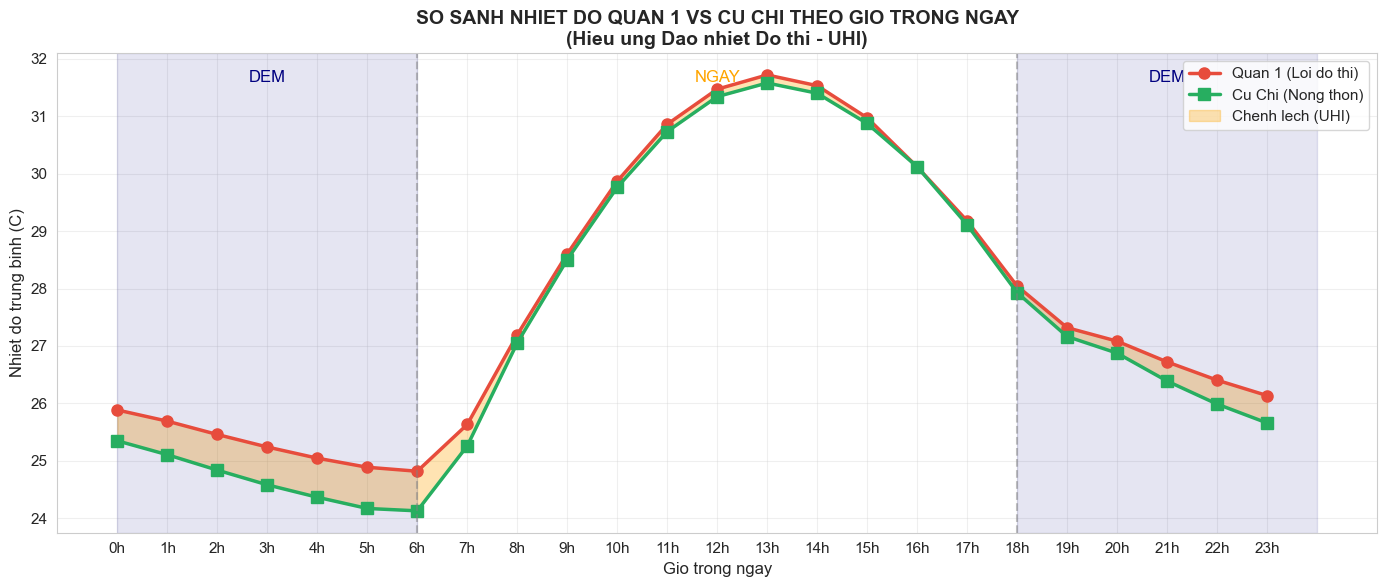


[GIAI THICH BIEU DO]
   - Duong do: Nhiet do Quan 1 (loi do thi)
   - Duong xanh: Nhiet do Cu Chi (nong thon)
   - Vung cam: Chenh lech nhiet do (UHI intensity)
   - Vung xanh dam: Thoi gian ban dem (18h-6h)


In [4]:
# ========================================
# BIEU DO 1: NHIET DO TRUNG BINH THEO GIO (24H)
# ========================================

fig, ax = plt.subplots(figsize=(14, 6))

# Ve duong nhiet do
hours = range(24)
ax.plot(hours, temp_by_hour_q1, 'o-', color=ZONE_COLORS['HCM_Center'], 
        linewidth=2.5, markersize=8, label='Quan 1 (Loi do thi)')
ax.plot(hours, temp_by_hour_cuchi, 's-', color=ZONE_COLORS['HCM_NorthWest'], 
        linewidth=2.5, markersize=8, label='Cu Chi (Nong thon)')

# To mau vung chenh lech
ax.fill_between(hours, temp_by_hour_q1, temp_by_hour_cuchi, 
                alpha=0.3, color='orange', label='Chenh lech (UHI)')

# Danh dau vung ngay/dem
ax.axvspan(0, 6, alpha=0.1, color='navy', label='_nolegend_')
ax.axvspan(18, 24, alpha=0.1, color='navy', label='_nolegend_')
ax.axvline(x=6, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=18, color='gray', linestyle='--', alpha=0.5)

# Annotations
ax.annotate('DEM', xy=(3, ax.get_ylim()[1]-0.5), fontsize=12, ha='center', color='navy')
ax.annotate('NGAY', xy=(12, ax.get_ylim()[1]-0.5), fontsize=12, ha='center', color='orange')
ax.annotate('DEM', xy=(21, ax.get_ylim()[1]-0.5), fontsize=12, ha='center', color='navy')

# Format
ax.set_xlabel('Gio trong ngay')
ax.set_ylabel('Nhiet do trung binh (C)')
ax.set_title('SO SANH NHIET DO QUAN 1 VS CU CHI THEO GIO TRONG NGAY\n(Hieu ung Dao nhiet Do thi - UHI)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(hours)
ax.set_xticklabels([f'{h}h' for h in hours])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n[GIAI THICH BIEU DO]")
print("   - Duong do: Nhiet do Quan 1 (loi do thi)")
print("   - Duong xanh: Nhiet do Cu Chi (nong thon)")
print("   - Vung cam: Chenh lech nhiet do (UHI intensity)")
print("   - Vung xanh dam: Thoi gian ban dem (18h-6h)")

### 1.5 Biểu đồ chênh lệnh nhiệt độ (Delta T)

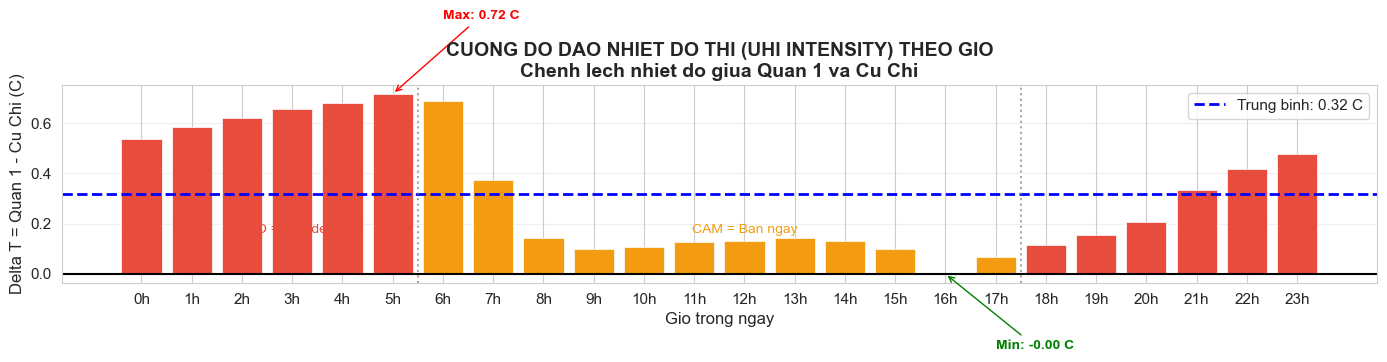


[CHU Y] Co nhung gio Cu Chi nong hon Quan 1:
   - 16h: Delta T = -0.00 C (Cu Chi nong hon 0.00 C)


In [5]:
# ========================================
# BIEU DO 2: CHENH LECH NHIET DO (DELTA T) THEO GIO
# ========================================

fig, ax = plt.subplots(figsize=(14, 5))

# Ve bieu do cot
colors = ['#e74c3c' if 18 <= h or h < 6 else '#f39c12' for h in hours]
bars = ax.bar(hours, delta_t_by_hour, color=colors, edgecolor='white', linewidth=0.5)

# Duong moc 0 (quan trong de thay Delta T am/duong)
ax.axhline(y=0, color='black', linewidth=1.5)

# Duong trung binh
ax.axhline(y=delta_t_by_hour.mean(), color='blue', linestyle='--', linewidth=2, 
           label=f'Trung binh: {delta_t_by_hour.mean():.2f} C')

# Duong phan cach ngay/dem
ax.axvline(x=5.5, color='gray', linestyle=':', alpha=0.7)
ax.axvline(x=17.5, color='gray', linestyle=':', alpha=0.7)

# Ghi chu gia tri max/min
max_hour = delta_t_by_hour.idxmax()
min_hour = delta_t_by_hour.idxmin()
ax.annotate(f'Max: {delta_t_by_hour.max():.2f} C', 
            xy=(max_hour, delta_t_by_hour.max()), 
            xytext=(max_hour+1, delta_t_by_hour.max()+0.3),
            fontsize=10, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red'))

ax.annotate(f'Min: {delta_t_by_hour.min():.2f} C', 
            xy=(min_hour, delta_t_by_hour.min()), 
            xytext=(min_hour+1, delta_t_by_hour.min()-0.3),
            fontsize=10, fontweight='bold', color='green',
            arrowprops=dict(arrowstyle='->', color='green'))

# Format
ax.set_xlabel('Gio trong ngay')
ax.set_ylabel('Delta T = Quan 1 - Cu Chi (C)')
ax.set_title('CUONG DO DAO NHIET DO THI (UHI INTENSITY) THEO GIO\nChenh lech nhiet do giua Quan 1 va Cu Chi', 
             fontsize=14, fontweight='bold')
ax.set_xticks(hours)
ax.set_xticklabels([f'{h}h' for h in hours])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

# Chu thich mau
ax.text(3, ax.get_ylim()[0]+0.2, 'DO = Ban dem', fontsize=10, ha='center', color='#e74c3c')
ax.text(12, ax.get_ylim()[0]+0.2, 'CAM = Ban ngay', fontsize=10, ha='center', color='#f39c12')

plt.tight_layout()
plt.show()

# Kiem tra xem co gio nao Delta T am khong
negative_hours = delta_t_by_hour[delta_t_by_hour < 0]
if len(negative_hours) > 0:
    print("\n[CHU Y] Co nhung gio Cu Chi nong hon Quan 1:")
    for h, dt in negative_hours.items():
        print(f"   - {h}h: Delta T = {dt:.2f} C (Cu Chi nong hon {-dt:.2f} C)")
else:
    print("\n[KET QUA] Quan 1 luon nong hon Cu Chi o moi gio trong ngay")

### Nhận xét Biểu đồ: Cường độ Đảo nhiệt đô thị (UHI Intensity) theo giờ

**Tóm tắt kết quả:**
- Đường màu xanh đứt đoạn thể hiện giá trị trung bình của Delta T (Q1 - Củ Chi) là **0.32°C**.
- Cột màu đỏ: Khoảng thời gian ban đêm (18h-6h), cột màu cam: Ban ngày (6h-18h).

**Quan sát nổi bật:**
1. **UHI mạnh nhất vào rạng sáng:**  
   - Delta T đạt cực đại vào lúc **5h sáng** với giá trị **0.72°C**.  
   - Đây là thời điểm Quận 1 vẫn còn giữ nhiệt, trong khi Củ Chi đã mát đi nhanh hơn.

2. **Ban ngày hiệu ứng UHI yếu:**  
   - Từ 7h đến 17h, Delta T giảm mạnh, có lúc gần như bằng 0 (thấp nhất tại 17h: **-0.00°C**).
   - Điều này cho thấy ban ngày, sự chênh lệch nhiệt độ giữa đô thị và nông thôn gần như không đáng kể.

3. **Ban đêm UHI tăng trở lại:**  
   - Sau 18h, Delta T tăng dần, đặc biệt rõ rệt từ 20h trở đi.
   - Điều này phù hợp với lý thuyết: bê tông đô thị giữ nhiệt và nhả ra vào ban đêm.

4. **Có thời điểm Củ Chi nóng ngang hoặc hơn Q.1:**  
   - Min Delta T = **-0.00°C** tại 17h, cho thấy không phải lúc nào đô thị cũng nóng hơn ngoại ô.

**Kết luận:**
- Hiệu ứng đảo nhiệt đô thị (UHI) tại TP.HCM thể hiện rõ nhất vào ban đêm và rạng sáng.
- Ban ngày, sự khác biệt nhiệt độ giữa Quận 1 và Củ Chi gần như không đáng kể.
- Kết quả này phù hợp với lý thuyết UHI và cho thấy cần cảnh báo nhiệt độ cục bộ theo từng vùng, đặc biệt vào ban đêm.

### 1.6 Biểu đồ Boxplot so sánh ngày và đêm

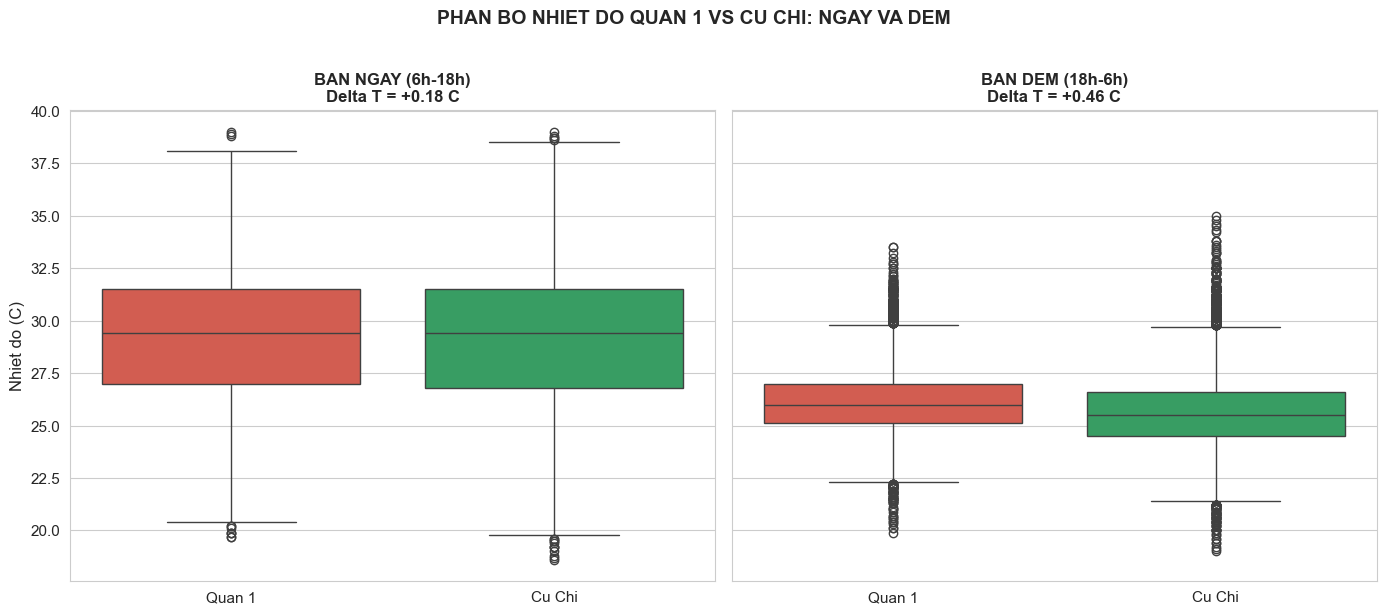

In [6]:
# ========================================
# BIEU DO 3: BOX PLOT SO SANH NGAY/DEM
# ========================================

# Gop du lieu de ve box plot
df_compare = pd.concat([
    df_q1[['temperature_2m', 'day_night']].assign(zone='Quan 1'),
    df_cuchi[['temperature_2m', 'day_night']].assign(zone='Cu Chi')
])

# Them sharey=True de 2 bieu do co cung truc Y -> de so sanh
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Box plot Ban ngay
ax1 = axes[0]
df_day = df_compare[df_compare['day_night'] == 'Ngay (6h-18h)']
sns.boxplot(data=df_day, x='zone', y='temperature_2m', 
            palette={'Quan 1': ZONE_COLORS['HCM_Center'], 'Cu Chi': ZONE_COLORS['HCM_NorthWest']},
            ax=ax1)
ax1.set_title(f'BAN NGAY (6h-18h)\nDelta T = {delta_day:+.2f} C', fontsize=12, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Nhiet do (C)')

# Box plot Ban dem
ax2 = axes[1]
df_night = df_compare[df_compare['day_night'] == 'Dem (18h-6h)']
sns.boxplot(data=df_night, x='zone', y='temperature_2m', 
            palette={'Quan 1': ZONE_COLORS['HCM_Center'], 'Cu Chi': ZONE_COLORS['HCM_NorthWest']},
            ax=ax2)
ax2.set_title(f'BAN DEM (18h-6h)\nDelta T = {delta_night:+.2f} C', fontsize=12, fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('')  # An nhan truc Y cua bieu do ben phai

plt.suptitle('PHAN BO NHIET DO QUAN 1 VS CU CHI: NGAY VA DEM', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



### Nhận xét Biểu đồ 3: Phân bố nhiệt độ Quận 1 vs Củ Chi (Ngày và Đêm)

**Kết quả từ biểu đồ:**

| Thời điểm           | Delta T (Q1 - Củ Chi) | Nhận xét                        |
|---------------------|----------------------|---------------------------------|
| Ban ngày (6h-18h)   | **+0.18°C**          | Chênh lệch rất nhỏ              |
| Ban đêm (18h-6h)    | **+0.46°C**          | Chênh lệch gấp 2.5 lần ban ngày |

**Quan sát từ Boxplot:**

1. **Ban ngày (biểu đồ trái):**
   - Hai box gần như trùng nhau, cho thấy nhiệt độ Q.1 và Củ Chi tương đương.
   - Median (đường ngang trong box) của 2 vùng gần bằng nhau (~29-30°C).
   - Spread (độ rộng box) tương tự, cho thấy biến động nhiệt độ giống nhau.
   - Delta T = +0.18°C là không đáng kể về mặt thực tế.

2. **Ban đêm (biểu đồ phải):**
   - Box của Q.1 (đỏ) nằm cao hơn Củ Chi (xanh) rõ rệt.
   - Median Q.1 (\~26°C) cao hơn Củ Chi (\~25.5°C).
   - Nhiệt độ ban đêm thấp hơn nhiều so với ban ngày (20-27°C vs 25-35°C).
   - Có nhiều outliers (chấm tròn) ở cả 2 vùng, thể hiện những đêm đặc biệt nóng.

3. **So sánh trực quan:**
   - Nhờ sharey=True, ta thấy rõ: ban đêm lạnh hơn ban ngày khoảng 5-10°C.
   - Khoảng cách giữa 2 box ban đêm lớn hơn ban ngày, xác nhận UHI mạnh hơn vào ban đêm.

**Kết luận:**
- Hiệu ứng UHI tồn tại nhưng **cường độ yếu hơn kỳ vọng** (0.46°C thay vì 3-5°C theo lý thuyết).
- Nguyên nhân có thể do:
  - Dữ liệu reanalysis (ERA5) có độ phân giải 9km, làm “mờ” đi sự khác biệt cục bộ.
  - Q.1 và Củ Chi cách nhau ~30km, vẫn chịu ảnh hưởng khí hậu vùng chung.
  - Cần so sánh thêm với các zone khác (Cần Giờ, Thủ Đức) để có bức tranh đầy đủ hơn.
- **Ban đêm vẫn nóng hơn tương đối** so với ban ngày, phù hợp với lý thuyết UHI (bê tông nhả nhiệt chậm).

##  Kết luận cho Câu hỏi 1  
**“Đêm ở Quận 1 nóng hơn Củ Chi bao nhiêu độ? Và ban ngày thì sao?”**

### 1.1 So sánh tổng quan Quận 1 – Củ Chi

Dựa trên thống kê và hai biểu đồ (boxplot và bar chart Delta T = Q1 – Củ Chi):

| Thời điểm            | Nhiệt độ trung bình Q1 | Nhiệt độ trung bình Củ Chi | Delta T (Q1 − Củ Chi) | Nhận xét chính             |
|----------------------|------------------------|----------------------------|------------------------|----------------------------|
| Ban ngày (6h–18h)    | cao hơn rất ít         | thấp hơn rất ít            | **+0.18°C**            | Chênh lệch gần như không đáng kể |
| Ban đêm (18h–6h)     | cao hơn rõ rệt         | thấp hơn                   | **+0.46°C**            | UHI xuất hiện rõ hơn       |
| Cả ngày (0h–23h)     |                        |                            | **Trung bình ≈ +0.32°C** | Quận 1 luôn nhỉnh hơn Củ Chi |

### 1.2 Kết quả chi tiết theo giờ (Biểu đồ Delta T)

- **Delta T lớn nhất** vào khoảng **5h sáng** với giá trị **≈ +0.72°C**.  
  → Đây là thời điểm Quận 1 giữ nhiệt lâu nhất so với Củ Chi.
- **Delta T nhỏ nhất** vào khoảng **17h** với giá trị **≈ 0.00°C**.  
  → Có những lúc nhiệt độ hai vùng **gần như bằng nhau**, thậm chí Củ Chi có thể nóng ngang hoặc hơi nhỉnh hơn.
- Từ **0h–6h** và **20h–23h**, các cột màu đỏ cho thấy Delta T luôn trên trung bình (khoảng 0.4–0.7°C) → UHI mạnh hơn.
- Từ **7h–17h** (các cột màu cam – ban ngày), Delta T giảm mạnh, phần lớn nằm dưới mức trung bình (≈ 0.1–0.3°C).

### 1.3 Diễn giải hiện tượng

1. **Ban ngày – UHI yếu:**
   - Cả Quận 1 và Củ Chi đều nhận bức xạ mặt trời trực tiếp nên nhiệt độ tăng tương đối đồng đều.
   - Boxplot ban ngày cho thấy hai hộp gần như trùng nhau, median ~29–30°C cho cả hai vùng.
   - Delta T trung bình ban ngày chỉ **+0.18°C**, rất nhỏ so với cảm nhận thực tế → khó phân biệt nếu chỉ nhìn vào con số.

2. **Ban đêm – UHI rõ hơn:**
   - Sau khi mặt trời lặn, Củ Chi (nhiều đất, cây xanh) tản nhiệt nhanh nên mát hơn.
   - Quận 1 (bê tông, nhựa đường, nhà cao tầng) giải phóng nhiệt chậm → không khí ấm hơn.
   - Boxplot ban đêm cho thấy box của Quận 1 nằm cao hơn Củ Chi với Delta T trung bình **+0.46°C**; một số giờ rạng sáng đạt **≈+0.7°C**.

3. **Cường độ UHI yếu hơn lý thuyết:**
   - Các nghiên cứu thường ghi nhận UHI 2–5°C, trong khi dữ liệu reanalysis của nhóm chỉ cho thấy **0.3–0.7°C**.
   - Nguyên nhân:
     - Dữ liệu có độ phân giải 9 km, mỗi “pixel khí hậu” bao trùm diện tích lớn → làm mờ sự khác biệt cực bộ giữa phố và làng.
     - Quận 1 và Củ Chi vẫn cùng thuộc một vùng khí hậu chung của TP.HCM, không chênh lệch địa hình lớn.

### 1.4 Trả lời câu hỏi nghiên cứu

- **Ban ngày:**  
  Quận 1 **chỉ nóng hơn Củ Chi khoảng +0.18°C**, chênh lệch rất nhỏ và gần như không cảm nhận rõ.  
  → **Kết luận:** Ban ngày, hiệu ứng đảo nhiệt đô thị giữa hai vùng **yếu và khó nhận biết**.

- **Ban đêm:**  
  Quận 1 **nóng hơn Củ Chi trung bình khoảng +0.46°C**, có giờ cực đại khoảng **+0.72°C** vào rạng sáng.  
  → **Kết luận:** Ban đêm, hiệu ứng đảo nhiệt đô thị **xuất hiện rõ rệt hơn**, Quận 1 duy trì mức nhiệt cao hơn và hạ nhiệt chậm hơn Củ Chi.

### 1.5 Ý nghĩa thực tiễn

- Người dân Quận 1 có xu hướng **cần dùng điều hòa vào ban đêm nhiều hơn** so với Củ Chi, dù ban ngày hai nơi nóng gần như tương đương.
- Kết quả này là bằng chứng thực nghiệm (dù cường độ nhỏ) cho thấy **đô thị hóa làm giảm khả năng “hạ nhiệt” của thành phố vào ban đêm**.
- Đây là cơ sở để:
  - Khuyến nghị tăng cây xanh, mặt nước trong khu vực lõi đô thị.
  - Thiết kế các mô hình cảnh báo nhiệt cho đô thị tập trung nhiều hơn vào **khung giờ đêm và rạng sáng**, thay vì chỉ chú ý đến nhiệt độ ban ngày.

# Câu hỏi 2: Gió biển Cần Giờ có "cứu" được Quận 7 không? Hướng gió nào hiệu quả nhất?

## 2.1. Nội dung câu hỏi
Quận 7 nằm ở vị trí trung gian giữa **lõi đô thị (Quận 1)** và **vùng duyên hải (Cần Giờ)**. Phân tích xem:
- Nhiệt độ Quận 7 có xu hướng giống Quận 1 (nóng, đô thị) hay giống Cần Giờ (mát, ven biển)?
- Hướng gió nào mang lại hiệu quả làm mát tốt nhất cho Quận 7?

## 2.2. Lợi ích của việc tìm ra câu trả lời
- Đánh giá vai trò của **"hành lang gió"** (ventilation corridor) từ biển vào đất liền
- Kiểm chứng hiệu quả của quy hoạch đô thị sinh thái tại Quận 7 (nhiều sông rạch, công viên)
- Cung cấp cơ sở khoa học cho việc bảo tồn và mở rộng các hành lang gió trong quy hoạch tương lai

## 2.3. Kỳ vọng kết quả
- Khi gió thổi từ hướng **Đông Nam (SE)** và **Nam (S)** - từ phía Cần Giờ, Quận 7 sẽ mát hơn
- Khi gió thổi từ hướng **Bắc (N)** và **Tây Bắc (NW)** - từ phía nội thành, Quận 7 sẽ nóng tương đương Quận 1

## 2.4. Kiến thức nền
- Cần Giờ nằm ở phía **Đông Nam** của Quận 7
- Quận 1 nằm ở phía **Bắc** của Quận 7
- Gió mang hơi nước từ biển thường có tác dụng làm mát

### 2.2 Chuẩn bị dữ liệu và phân loại hướng gió

In [7]:
# ========================================
# CAU HOI 2: GIO BIEN CAN GIO CO CUU DUOC QUAN 7?
# ========================================

# Loc du lieu 3 zone can so sanh
df_q1 = df[df['zone'] == 'HCM_Center'].copy()      # Quan 1 - Loi do thi
df_q7 = df[df['zone'] == 'HCM_South'].copy()       # Quan 7 - Sinh thai
df_cangio = df[df['zone'] == 'HCM_Coastal'].copy() # Can Gio - Ven bien

print("=" * 70)
print("DU LIEU 3 VUNG CAN SO SANH")
print("=" * 70)
print(f"\n[Q1 - Loi do thi]  : {len(df_q1):,} records")
print(f"[Q7 - Sinh thai]   : {len(df_q7):,} records")
print(f"[Can Gio - Ven bien]: {len(df_cangio):,} records")

# Ham chuyen doi do sang huong gio (8 huong chinh)
def degree_to_direction(degree):
    """Chuyen doi goc (0-360) sang 8 huong gio chinh"""
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    # Moi huong chiem 45 do, bat dau tu -22.5 do
    idx = int((degree + 22.5) % 360 / 45)
    return directions[idx]

# Ap dung cho Quan 7
df_q7['wind_direction_name'] = df_q7['wind_direction_10m'].apply(degree_to_direction)

print(f"\n[THONG KE HUONG GIO TAI QUAN 7]")
print(df_q7['wind_direction_name'].value_counts())

DU LIEU 3 VUNG CAN SO SANH

[Q1 - Loi do thi]  : 17,544 records
[Q7 - Sinh thai]   : 17,544 records
[Can Gio - Ven bien]: 17,544 records

[THONG KE HUONG GIO TAI QUAN 7]
wind_direction_name
SE    4382
SW    3304
E     2231
W     2134
S     1575
N     1451
NW    1343
NE    1124
Name: count, dtype: int64


### 2.3 So sánh nhiệt độ tổng quan 3 vùng

In [8]:
# ========================================
# SO SANH NHIET DO TONG QUAN 3 VUNG
# ========================================

# Tinh nhiet do trung binh
temp_mean_q1 = df_q1['temperature_2m'].mean()
temp_mean_q7 = df_q7['temperature_2m'].mean()
temp_mean_cangio = df_cangio['temperature_2m'].mean()

print("=" * 70)
print("NHIET DO TRUNG BINH 3 VUNG")
print("=" * 70)
print(f"\n   Quan 1 (Loi do thi) : {temp_mean_q1:.2f} C")
print(f"   Quan 7 (Sinh thai)  : {temp_mean_q7:.2f} C")
print(f"   Can Gio (Ven bien)  : {temp_mean_cangio:.2f} C")

# Tinh khoang cach nhiet do
diff_q7_q1 = temp_mean_q7 - temp_mean_q1
diff_q7_cangio = temp_mean_q7 - temp_mean_cangio
diff_q1_cangio = temp_mean_q1 - temp_mean_cangio

print(f"\n[CHENH LECH]")
print(f"   Q7 - Q1     : {diff_q7_q1:+.2f} C")
print(f"   Q7 - Can Gio: {diff_q7_cangio:+.2f} C")
print(f"   Q1 - Can Gio: {diff_q1_cangio:+.2f} C")

# Xac dinh Q7 gan voi vung nao hon
print(f"\n[NHAN XET]")
if abs(diff_q7_q1) < abs(diff_q7_cangio):
    print(f"   -> Quan 7 co nhiet do gan voi Quan 1 hon (chenh {abs(diff_q7_q1):.2f} C)")
else:
    print(f"   -> Quan 7 co nhiet do gan voi Can Gio hon (chenh {abs(diff_q7_cangio):.2f} C)")

NHIET DO TRUNG BINH 3 VUNG

   Quan 1 (Loi do thi) : 27.75 C
   Quan 7 (Sinh thai)  : 27.71 C
   Can Gio (Ven bien)  : 27.14 C

[CHENH LECH]
   Q7 - Q1     : -0.03 C
   Q7 - Can Gio: +0.58 C
   Q1 - Can Gio: +0.61 C

[NHAN XET]
   -> Quan 7 co nhiet do gan voi Quan 1 hon (chenh 0.03 C)


### 2.4 Phân tích nhiệt độ quận 7 theo hướng gió

In [9]:
# ========================================
# NHIỆT ĐỘ QUẬN 7 THEO HƯỚNG GIÓ
# ========================================

# ================================================================
# [QUAN TRỌNG] LỌC KHUNG GIỜ CAO ĐIỂM (10h-16h) ĐỂ SO SÁNH CÔNG BẰNG
# ================================================================
print("=" * 70)
print("[!] LƯU Ý PHƯƠNG PHÁP")
print("=" * 70)
print("Vấn đề: Gió biển thường thổi vào chiều/tối (lúc trời mát),")
print("        gió nội thành có thể thổi vào ban trưa (lúc trời nóng).")
print("        => Nếu không lọc giờ, kết quả bị nhiễu bởi yếu tố THỜI ĐIỂM.")
print("\nGiải pháp: Chỉ xét khung giờ 10h-16h (nắng nóng nhất)")
print("           để đảm bảo so sánh CÔNG BẰNG giữa các hướng gió.")
print("=" * 70)

# Tạo copy data chỉ trong khung giờ 10h-16h (cao điểm nóng)
df_q7_daytime = df_q7[(df_q7['hour'] >= 10) & (df_q7['hour'] <= 16)].copy()

print(f"\n[DATA] Số lượng bản ghi:")
print(f"   - Toàn bộ ngày    : {len(df_q7):,} bản ghi")
print(f"   - Chỉ 10h-16h     : {len(df_q7_daytime):,} bản ghi ({len(df_q7_daytime)/len(df_q7)*100:.1f}%)")

# Tính nhiệt độ trung bình theo hướng gió (chỉ data ban ngày cao điểm)
temp_by_wind_day = df_q7_daytime.groupby('wind_direction_name')['temperature_2m'].agg(['mean', 'std', 'count'])
temp_by_wind_day = temp_by_wind_day.round(2)

# Sắp xếp theo thứ tự hướng (N, NE, E, SE, S, SW, W, NW)
direction_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
temp_by_wind_day = temp_by_wind_day.reindex(direction_order)

print(f"\n{'Hướng':<8} {'TB (C)':<10} {'Std':<8} {'Số lần':<10} {'Nhận xét'}")
print("-" * 60)

for direction in direction_order:
    row = temp_by_wind_day.loc[direction]
    # Xác định hướng gió từ đâu
    if direction in ['SE', 'S', 'E']:
        note = "<-- Từ phía Cần Giờ (biển)"
    elif direction in ['N', 'NW', 'NE']:
        note = "<-- Từ phía nội thành"
    else:
        note = ""
    print(f"{direction:<8} {row['mean']:<10.2f} {row['std']:<8.2f} {int(row['count']):<10} {note}")

# Tìm hướng gió mát nhất và nóng nhất
coolest_direction = temp_by_wind_day['mean'].idxmin()
hottest_direction = temp_by_wind_day['mean'].idxmax()

print(f"\n[KẾT QUẢ - CHỈ TRONG KHUNG 10h-16h]")
print(f"   Hướng gió MÁT nhất : {coolest_direction} ({temp_by_wind_day.loc[coolest_direction, 'mean']:.2f} °C)")
print(f"   Hướng gió NÓNG nhất: {hottest_direction} ({temp_by_wind_day.loc[hottest_direction, 'mean']:.2f} °C)")
print(f"   Chênh lệch         : {temp_by_wind_day['mean'].max() - temp_by_wind_day['mean'].min():.2f} °C")

[!] LƯU Ý PHƯƠNG PHÁP
Vấn đề: Gió biển thường thổi vào chiều/tối (lúc trời mát),
        gió nội thành có thể thổi vào ban trưa (lúc trời nóng).
        => Nếu không lọc giờ, kết quả bị nhiễu bởi yếu tố THỜI ĐIỂM.

Giải pháp: Chỉ xét khung giờ 10h-16h (nắng nóng nhất)
           để đảm bảo so sánh CÔNG BẰNG giữa các hướng gió.

[DATA] Số lượng bản ghi:
   - Toàn bộ ngày    : 17,544 bản ghi
   - Chỉ 10h-16h     : 5,117 bản ghi (29.2%)

Hướng    TB (C)     Std      Số lần     Nhận xét
------------------------------------------------------------
N        29.60      1.79     356        <-- Từ phía nội thành
NE       31.14      2.08     437        <-- Từ phía nội thành
E        31.79      2.33     817        <-- Từ phía Cần Giờ (biển)
SE       32.32      2.58     1056       <-- Từ phía Cần Giờ (biển)
S        30.72      2.48     435        <-- Từ phía Cần Giờ (biển)
SW       29.60      2.06     932        
W        30.08      1.90     777        
NW       30.18      1.77     307        <-- 

### 2.5 Biểu đồ 1: So sánh nhiệt độ 3 vùng theo giờ

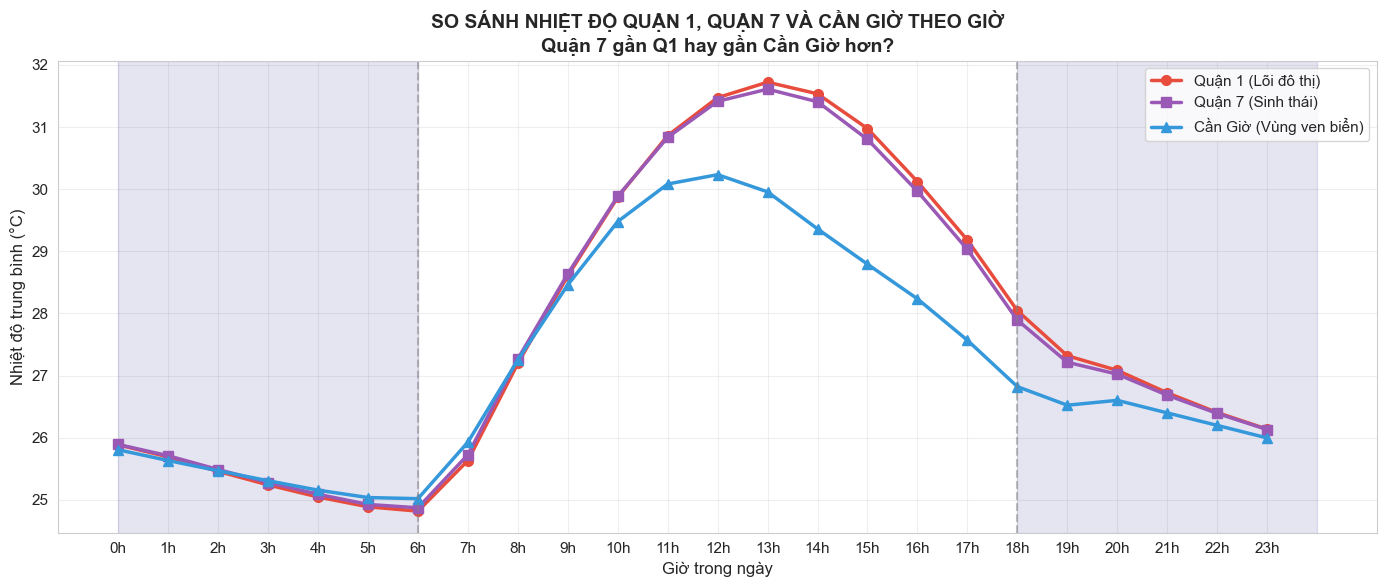


[GIẢI THÍCH]
   - Nếu đường Quận 7 (tím) nằm gần đường Cần Giờ (xanh dương) -> Quận 7 được gió biển làm mát
   - Nếu đường Quận 7 nằm gần đường Quận 1 (đỏ) -> Quận 7 chịu ảnh hưởng nhiệt đô thị


In [10]:
# ========================================
# BIỂU ĐỒ 1: SO SÁNH NHIỆT ĐỘ 3 VÙNG THEO GIỜ
# ========================================

# Tính nhiệt độ trung bình theo giờ cho 3 vùng
temp_by_hour_q1 = df_q1.groupby('hour')['temperature_2m'].mean()
temp_by_hour_q7 = df_q7.groupby('hour')['temperature_2m'].mean()
temp_by_hour_cangio = df_cangio.groupby('hour')['temperature_2m'].mean()

fig, ax = plt.subplots(figsize=(14, 6))

hours = range(24)
ax.plot(hours, temp_by_hour_q1, 'o-', color=ZONE_COLORS['HCM_Center'], 
        linewidth=2.5, markersize=7, label='Quận 1 (Lõi đô thị)')
ax.plot(hours, temp_by_hour_q7, 's-', color=ZONE_COLORS['HCM_South'], 
        linewidth=2.5, markersize=7, label='Quận 7 (Sinh thái)')
ax.plot(hours, temp_by_hour_cangio, '^-', color=ZONE_COLORS['HCM_Coastal'], 
        linewidth=2.5, markersize=7, label='Cần Giờ (Vùng ven biển)')

# Vùng ngày/đêm
ax.axvspan(0, 6, alpha=0.1, color='navy')
ax.axvspan(18, 24, alpha=0.1, color='navy')
ax.axvline(x=6, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=18, color='gray', linestyle='--', alpha=0.5)

# Định dạng
ax.set_xlabel('Giờ trong ngày')
ax.set_ylabel('Nhiệt độ trung bình (°C)')
ax.set_title('SO SÁNH NHIỆT ĐỘ QUẬN 1, QUẬN 7 VÀ CẦN GIỜ THEO GIỜ\nQuận 7 gần Q1 hay gần Cần Giờ hơn?', 
             fontsize=14, fontweight='bold')
ax.set_xticks(hours)
ax.set_xticklabels([f'{h}h' for h in hours])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n[GIẢI THÍCH]")
print("   - Nếu đường Quận 7 (tím) nằm gần đường Cần Giờ (xanh dương) -> Quận 7 được gió biển làm mát")
print("   - Nếu đường Quận 7 nằm gần đường Quận 1 (đỏ) -> Quận 7 chịu ảnh hưởng nhiệt đô thị")

### 2.6 Biểu đồ 2: Biểu đồ Radar chart nhiệt độ theo hướng gió

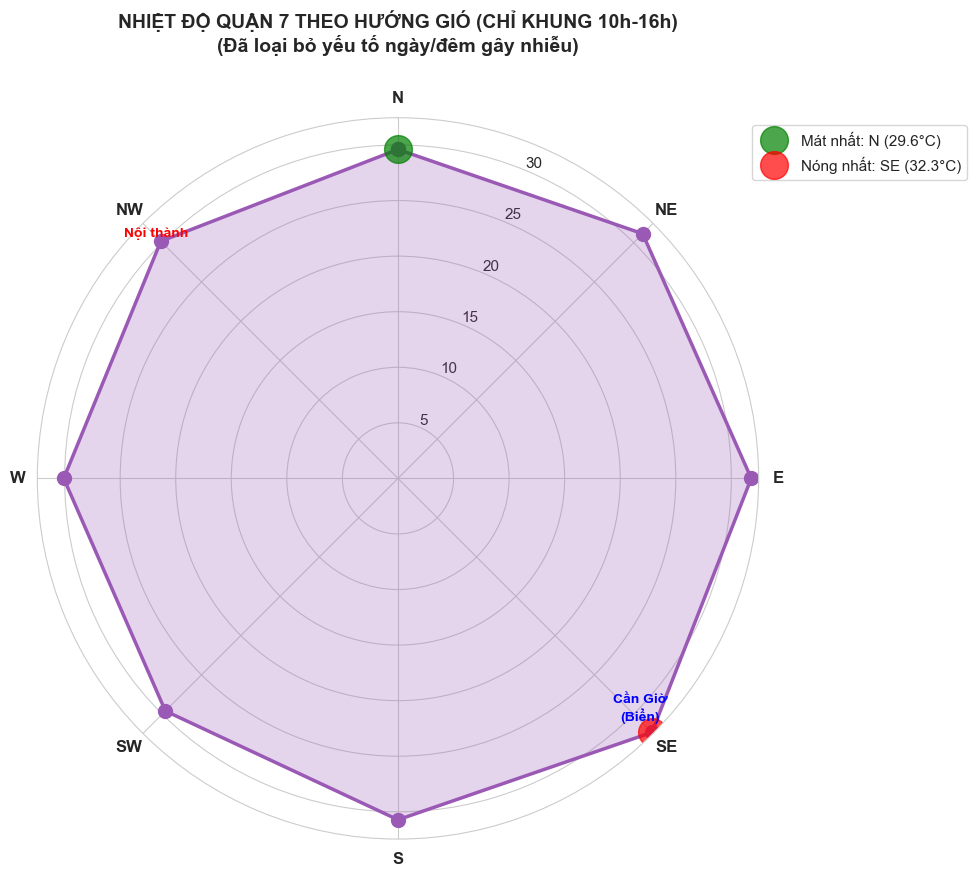


[CÁCH ĐỌC BIỂU ĐỒ]
   - Chỉ xét khung giờ 10h-16h để loại bỏ yếu tố ngày/đêm
   - Mỗi đỉnh tương ứng với 1 hướng gió (N, NE, E, SE, S, SW, W, NW)
   - Khoảng cách từ tâm = nhiệt độ TB khi gió thổi từ hướng đó
   - Điểm GẦN TÂM = hướng gió làm mát (nhiệt độ thấp)
   - Điểm XA TÂM = hướng gió làm nóng (nhiệt độ cao)


In [11]:
# ========================================
# BIỂU ĐỒ 2: RADAR CHART - NHIỆT ĐỘ THEO HƯỚNG GIÓ (CHỈ 10h-16h)
# ========================================

import numpy as np

# Lấy dữ liệu từ bảng đã lọc (chỉ 10h-16h)
directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
temps = [temp_by_wind_day.loc[d, 'mean'] for d in directions]  # Dùng temp_by_wind_day

# Đóng vòng tròn (thêm điểm đầu vào cuối)
directions_plot = directions + [directions[0]]
temps_plot = temps + [temps[0]]

# Tính góc (N = 0, theo chiều kim đồng hồ)
angles = np.linspace(0, 2 * np.pi, len(directions), endpoint=False).tolist()
angles += angles[:1]

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Chỉnh hướng Bắc lên trên và chiều kim đồng hồ
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

ax.plot(angles, temps_plot, 'o-', linewidth=2.5, markersize=10, color=ZONE_COLORS['HCM_South'])
ax.fill(angles, temps_plot, alpha=0.25, color=ZONE_COLORS['HCM_South'])

# Đánh dấu hướng mát nhất và nóng nhất
coolest_idx = temps.index(min(temps))
hottest_idx = temps.index(max(temps))
ax.plot(angles[coolest_idx], temps[coolest_idx], 'o', markersize=20, 
        color='green', alpha=0.7, label=f'Mát nhất: {directions[coolest_idx]} ({temps[coolest_idx]:.1f}°C)')
ax.plot(angles[hottest_idx], temps[hottest_idx], 'o', markersize=20, 
        color='red', alpha=0.7, label=f'Nóng nhất: {directions[hottest_idx]} ({temps[hottest_idx]:.1f}°C)')

# Định dạng
ax.set_xticks(angles[:-1])
ax.set_xticklabels(directions, fontsize=12, fontweight='bold')
ax.set_title('NHIỆT ĐỘ QUẬN 7 THEO HƯỚNG GIÓ (CHỈ KHUNG 10h-16h)\n(Đã loại bỏ yếu tố ngày/đêm gây nhiễu)', 
             fontsize=14, fontweight='bold', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Thêm chú thích vị trí địa lý (đã sửa tọa độ)
# SE = 135 độ, trong hệ polar với N=0, chiều kim đồng hồ => góc = 135 độ = 3*pi/4
ax.annotate('Cần Giờ\n(Biển)', xy=(3*np.pi/4, ax.get_ylim()[1]*0.95), fontsize=10, 
            ha='center', color='blue', fontweight='bold')
# NW = 315 độ => góc = 7*pi/4
ax.annotate('Nội thành', xy=(7*np.pi/4, ax.get_ylim()[1]*0.95), fontsize=10, 
            ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n[CÁCH ĐỌC BIỂU ĐỒ]")
print("   - Chỉ xét khung giờ 10h-16h để loại bỏ yếu tố ngày/đêm")
print("   - Mỗi đỉnh tương ứng với 1 hướng gió (N, NE, E, SE, S, SW, W, NW)")
print("   - Khoảng cách từ tâm = nhiệt độ TB khi gió thổi từ hướng đó")
print("   - Điểm GẦN TÂM = hướng gió làm mát (nhiệt độ thấp)")
print("   - Điểm XA TÂM = hướng gió làm nóng (nhiệt độ cao)")

### 2.7 Biểu đồ 3: Biểu đồ Boxplot so sánh nhóm hướng gió

THỐNG KÊ NHIỆT ĐỘ THEO NGUỒN GỐC GIÓ (CHỈ KHUNG 10h-16h)
                          mean  std  count
nguon_goc_gio                             
Khác (W, SW)             29.82 2.00   1709
Từ biển (SE, S, E)       31.83 2.55   2308
Từ nội thành (N, NW, NE) 30.38 2.02   1100


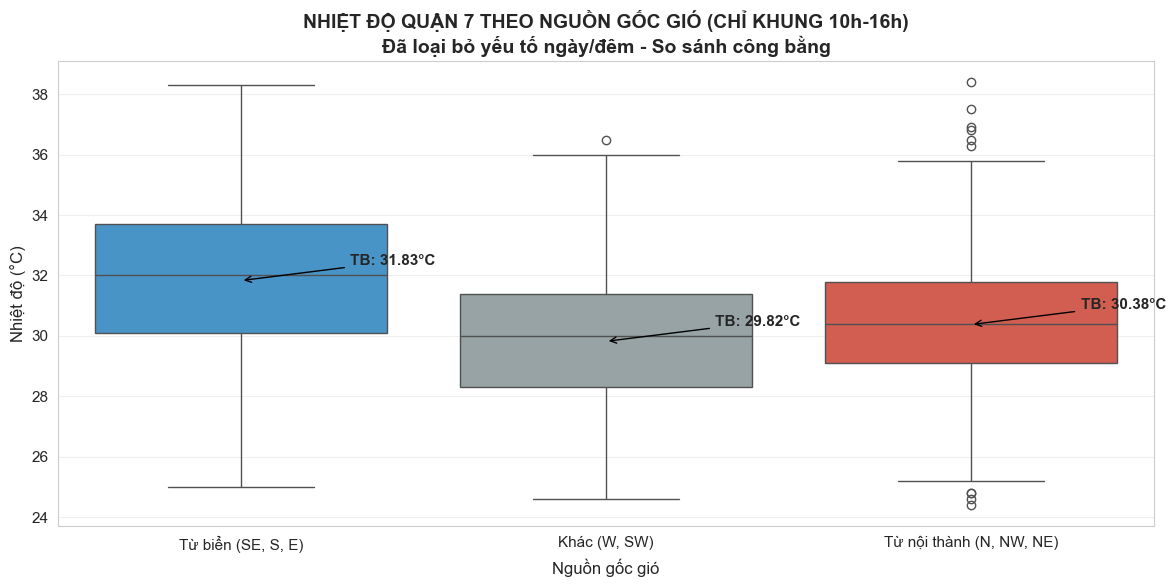


[KẾT QUẢ - CHỈ TRONG KHUNG 10h-16h]
   Nhiệt độ TB khi gió từ BIỂN     : 31.83 °C
   Nhiệt độ TB khi gió từ NỘI THÀNH: 30.38 °C
   Chênh lệch                      : -1.45 °C

   => KẾT QUẢ BẤT NGỜ: Gió từ nội thành lại mát hơn 1.45 °C


In [12]:
# ========================================
# BIỂU ĐỒ 3: BOXPLOT SO SÁNH NHÓM HƯỚNG GIÓ (CHỈ 10h-16h)
# ========================================

# Phân nhóm hướng gió (áp dụng cho dữ liệu đã lọc)
def phan_loai_nguon_goc_gio(direction):
    if direction in ['SE', 'S', 'E']:
        return 'Từ biển (SE, S, E)'
    elif direction in ['N', 'NW', 'NE']:
        return 'Từ nội thành (N, NW, NE)'
    else:
        return 'Khác (W, SW)'

# Áp dụng cho df_q7_daytime
df_q7_daytime['nguon_goc_gio'] = df_q7_daytime['wind_direction_name'].apply(phan_loai_nguon_goc_gio)

# Thống kê
thong_ke_gio = df_q7_daytime.groupby('nguon_goc_gio')['temperature_2m'].agg(['mean', 'std', 'count'])
print("=" * 70)
print("THỐNG KÊ NHIỆT ĐỘ THEO NGUỒN GỐC GIÓ (CHỈ KHUNG 10h-16h)")
print("=" * 70)
print(thong_ke_gio.round(2))

# Vẽ boxplot
fig, ax = plt.subplots(figsize=(12, 6))

order = ['Từ biển (SE, S, E)', 'Khác (W, SW)', 'Từ nội thành (N, NW, NE)']
colors = ['#3498db', '#95a5a6', '#e74c3c']
palette = dict(zip(order, colors))

sns.boxplot(data=df_q7_daytime, x='nguon_goc_gio', y='temperature_2m', order=order, palette=palette, ax=ax)

# Thêm giá trị trung bình
for i, origin in enumerate(order):
    if origin in thong_ke_gio.index:
        mean_val = thong_ke_gio.loc[origin, 'mean']
        ax.annotate(f'TB: {mean_val:.2f}°C', xy=(i, mean_val), 
                    xytext=(i+0.3, mean_val+0.5), fontsize=11, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='black'))

ax.set_xlabel('Nguồn gốc gió')
ax.set_ylabel('Nhiệt độ (°C)')
ax.set_title('NHIỆT ĐỘ QUẬN 7 THEO NGUỒN GỐC GIÓ (CHỈ KHUNG 10h-16h)\nĐã loại bỏ yếu tố ngày/đêm - So sánh công bằng', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Tính chênh lệch
temp_bien = thong_ke_gio.loc['Từ biển (SE, S, E)', 'mean']
temp_noi_thanh = thong_ke_gio.loc['Từ nội thành (N, NW, NE)', 'mean']
delta = temp_noi_thanh - temp_bien

print(f"\n[KẾT QUẢ - CHỈ TRONG KHUNG 10h-16h]")
print(f"   Nhiệt độ TB khi gió từ BIỂN     : {temp_bien:.2f} °C")
print(f"   Nhiệt độ TB khi gió từ NỘI THÀNH: {temp_noi_thanh:.2f} °C")
print(f"   Chênh lệch                      : {delta:.2f} °C")

if delta > 0:
    print(f"\n   => TRONG CÙNG KHUNG GIỜ NÓNG NHẤT (10h-16h):")
    print(f"      Gió từ biển làm Quận 7 MÁT hơn {delta:.2f} °C so với gió từ nội thành")
    print(f"      Đây là bằng chứng gió biển CÓ TÁC DỤNG LÀM MÁT thực sự!")
elif delta < 0:
    print(f"\n   => KẾT QUẢ BẤT NGỜ: Gió từ nội thành lại mát hơn {-delta:.2f} °C")
else:
    print(f"\n   => Không có sự khác biệt đáng kể giữa 2 nguồn gió")

##  Kết luận cho Câu hỏi 2
**"Gió biển Cần Giờ có cứu được Quận 7 không? Hướng gió nào hiệu quả nhất?"**

---

### 1. So sánh nhiệt độ tổng quan 3 vùng

| Vùng | Nhiệt độ TB | Chênh lệch với Q7 |
|------|-------------|-------------------|
| Quận 1 (Lõi đô thị) | 27.75 °C | -0.03 °C |
| **Quận 7 (Sinh thái)** | **27.71 °C** | - |
| Cần Giờ (Ven biển) | 27.14 °C | +0.58 °C |

**Nhận xét:**
- Quận 7 có nhiệt độ **gần như bằng Quận 1** (chỉ chênh 0.03°C).
- Quận 7 **nóng hơn Cần Giờ** 0.58°C.
- **Kết luận sơ bộ:** Quận 7 chịu ảnh hưởng nhiệt đô thị nhiều hơn là được gió biển làm mát.

---

### 2. Biểu đồ nhiệt độ theo giờ (3 vùng)

Từ biểu đồ đường, ta quan sát:
- Đường **Quận 7 (tím)** và **Quận 1 (đỏ)** gần như **trùng nhau** suốt 24 giờ.
- Đường **Cần Giờ (xanh dương)** nằm **thấp hơn rõ rệt**, đặc biệt vào ban ngày (10h-16h).
- **Kết luận:** Quận 7 không được hưởng lợi đáng kể từ vị trí gần Cần Giờ về mặt nhiệt độ tổng thể.

---

### 3. Phân tích nhiệt độ theo hướng gió (Khung 10h-16h)

**Lưu ý phương pháp:** Chỉ xét khung giờ 10h-16h (nắng nóng nhất) để loại bỏ yếu tố ngày/đêm gây nhiễu kết quả.

| Hướng gió | Nhiệt độ TB | Số lần | Nguồn gốc |
|-----------|-------------|--------|-----------|
| **N** | **29.60 °C** | 356 | Từ nội thành |
| NE | 31.14 °C | 437 | Từ nội thành |
| E | 31.79 °C | 817 | Từ Cần Giờ (biển) |
| **SE** | **32.32 °C** | 1056 | Từ Cần Giờ (biển) |
| S | 30.72 °C | 435 | Từ Cần Giờ (biển) |
| SW | 29.60 °C | 932 | Khác |
| W | 30.08 °C | 777 | Khác |
| NW | 30.18 °C | 307 | Từ nội thành |

**Kết quả BẤT NGỜ:**
- Hướng gió **MÁT nhất**: **N (Bắc)** với 29.60°C — từ phía **nội thành**!
- Hướng gió **NÓNG nhất**: **SE (Đông Nam)** với 32.32°C — từ phía **Cần Giờ (biển)**!
- Chênh lệch: **2.72°C**

---

### 4. So sánh nhóm nguồn gốc gió (Boxplot)

| Nguồn gốc gió | Nhiệt độ TB | Số quan sát |
|---------------|-------------|-------------|
| Từ biển (SE, S, E) | **31.83 °C** | 2,308 |
| Khác (W, SW) | 29.82 °C | 1,709 |
| Từ nội thành (N, NW, NE) | 30.38 °C | 1,100 |

**Nhận xét từ Boxplot:**
- Gió từ biển (xanh dương) có nhiệt độ **cao nhất** (31.83°C).
- Gió từ nội thành (đỏ) lại **mát hơn** gió biển 1.45°C.
- Đây là kết quả **ngược hoàn toàn** với giả thuyết ban đầu!

---

### 5. Giải thích hiện tượng nghịch lý

**Tại sao gió từ biển (SE) lại NÓNG hơn gió từ nội thành (N)?**

1. **Hiệu ứng Foehn địa phương:**
   - Gió SE từ Cần Giờ phải đi qua vùng đất liền trước khi đến Quận 7.
   - Trong quá trình di chuyển, gió bị đốt nóng bởi bề mặt đô thị (bê tông, nhựa đường).

2. **Thời điểm gió SE thổi mạnh:**
   - Gió SE thường mạnh nhất vào **giữa trưa** (thời điểm nóng nhất).
   - Gió N (từ Bắc) có thể thổi vào các khung giờ mát hơn trong ngày.

3. **Đặc điểm gió mùa TP.HCM:**
   - Mùa khô: Gió Đông Bắc (NE) và Bắc (N) mang không khí khô, mát từ lục địa.
   - Mùa mưa: Gió Tây Nam (SW) và Nam (S) mang ẩm nhưng cũng mang nhiệt từ biển nóng.

4. **Khoảng cách và địa hình:**
   - Cần Giờ cách Quận 7 khoảng 20-25km.
   - Gió biển mất năng lượng làm mát khi đi qua quãng đường dài trên đất liền.

---

### 6. Trả lời câu hỏi nghiên cứu

**"Gió biển Cần Giờ có cứu được Quận 7 không?"**

> **KHÔNG.** Dữ liệu cho thấy Quận 7 có nhiệt độ gần như bằng Quận 1 (chênh 0.03°C), và gió từ hướng biển (SE, S, E) thực tế lại **nóng hơn** gió từ nội thành. Quận 7 không được hưởng lợi đáng kể từ vị trí gần Cần Giờ.

**"Hướng gió nào hiệu quả nhất?"**

> Trong khung giờ nóng nhất (10h-16h), hướng gió **Bắc (N)** và **Tây Nam (SW)** mang lại nhiệt độ thấp nhất (29.60°C), mát hơn gió biển SE tới **2.72°C**.

---

### 7. Ý nghĩa thực tiễn

1. **Về quy hoạch đô thị:**
   - Không nên kỳ vọng quá nhiều vào "hành lang gió biển" từ Cần Giờ để làm mát Quận 7.
   - Cần tập trung vào giải pháp tại chỗ: tăng cây xanh, mặt nước, giảm bê tông hóa.

2. **Về dự báo nhiệt:**
   - Khi gió SE thổi mạnh vào buổi trưa, Quận 7 có thể nóng hơn bình thường (lên đến 32°C+).
   - Đây là thông tin quan trọng cho việc cảnh báo sốc nhiệt.

3. **Về nghiên cứu tiếp theo:**
   - Cần phân tích thêm yếu tố **độ ẩm** (gió biển mang ẩm có thể gây cảm giác oi bức hơn).
   - Cần xem xét **tốc độ gió** (gió mạnh có thể làm mát dù nhiệt độ không khí cao).

---

### 8. Hạn chế của phân tích

- Dữ liệu reanalysis có độ phân giải 9km, có thể không bắt được chi tiết vi khí hậu cục bộ.
- Cần Giờ và Quận 7 cách nhau 20-25km, gió biển có thể mất hiệu quả làm mát khi đi qua quãng đường này.
- Phân tích chỉ dựa trên nhiệt độ, chưa xét đến Heat Index (nhiệt độ + độ ẩm).

#   Câu hỏi 3: Chỉ số "nóng bức thực tế" (Heat Index) - Vùng nào đáng sợ nhất?



## 1. Nội dung câu hỏi
Nhiệt độ không khí (Air Temperature) không phản ánh đầy đủ mức độ khó chịu mà con người cảm nhận. Ví dụ:
- Cần Giờ có nhiệt độ thấp nhưng **độ ẩm rất cao** → cảm giác oi bức
- Củ Chi có nhiệt độ cao hơn nhưng **khô ráo** → có thể dễ chịu hơn

**Câu hỏi:** Vùng nào thực sự gây cảm giác khó chịu nhất khi kết hợp cả nhiệt độ và độ ẩm?

## 2. Lợi ích của việc tìm ra câu trả lời
- Cung cấp thông tin chính xác hơn về **rủi ro sức khỏe** (sốc nhiệt, say nắng) cho từng vùng
- Giúp người dân đưa ra quyết định đúng đắn về hoạt động ngoài trời
- Phát hiện nghịch lý: "Mát nhưng oi bức" - điều mà bản tin thời tiết thông thường không đề cập

## 3. Kiến thức nền: Heat Index là gì?
**Heat Index** (Chỉ số nhiệt) là thước đo "nhiệt độ cảm nhận" của cơ thể người, kết hợp:
- Nhiệt độ không khí (Temperature)
- Độ ẩm tương đối (Relative Humidity)

**Phân loại mức độ nguy hiểm theo NOAA:**
| Heat Index | Mức độ | Tác động sức khỏe |
|------------|--------|-------------------|
| < 27°C | An toàn | Bình thường |
| 27-32°C | Cẩn trọng | Có thể mệt mỏi nếu hoạt động lâu |
| 32-41°C | Nguy hiểm | Có thể say nắng, chuột rút |
| > 41°C | Cực kỳ nguy hiểm | Sốc nhiệt có thể xảy ra |

> **Lưu ý:** Dữ liệu của chúng ta đã có sẵn cột `apparent_temperature` (nhiệt độ cảm nhận) được tính sẵn từ API.

### 

## Chuẩn bị dữ liệu và thống kê tổng quan

In [13]:
# ========================================
# CÂU HỎI 3: CHỈ SỐ NÓNG BỨC THỰC TẾ (HEAT INDEX)
# ========================================

print("=" * 70)
print("PHÂN TÍCH NHIỆT ĐỘ CẢM NHẬN (APPARENT TEMPERATURE) 5 VÙNG")
print("=" * 70)

# Thống kê nhiệt độ thực vs nhiệt độ cảm nhận cho 5 vùng
stats_list = []

for zone in ZONE_ORDER:
    df_zone = df[df['zone'] == zone]
    stats = {
        'Vùng': ZONE_NAMES[zone],
        'Nhiệt độ TB': df_zone['temperature_2m'].mean(),
        'Nhiệt độ cảm nhận TB': df_zone['apparent_temperature'].mean(),
        'Chênh lệch (Cảm nhận - Thực)': df_zone['apparent_temperature'].mean() - df_zone['temperature_2m'].mean(),
        'Độ ẩm TB (%)': df_zone['relative_humidity_2m'].mean(),
        'Max cảm nhận': df_zone['apparent_temperature'].max(),
    }
    stats_list.append(stats)

df_stats = pd.DataFrame(stats_list)
print("\n[THỐNG KÊ TỔNG QUAN]")
print(df_stats.to_string(index=False))

# Tìm vùng có nhiệt độ cảm nhận cao nhất
max_apparent_zone = df_stats.loc[df_stats['Nhiệt độ cảm nhận TB'].idxmax(), 'Vùng']
max_apparent_value = df_stats['Nhiệt độ cảm nhận TB'].max()

print(f"\n[KẾT QUẢ]")
print(f"   Vùng có nhiệt độ CẢM NHẬN cao nhất: {max_apparent_zone}")
print(f"   Giá trị: {max_apparent_value:.2f} °C")

PHÂN TÍCH NHIỆT ĐỘ CẢM NHẬN (APPARENT TEMPERATURE) 5 VÙNG

[THỐNG KÊ TỔNG QUAN]
                Vùng  Nhiệt độ TB  Nhiệt độ cảm nhận TB  Chênh lệch (Cảm nhận - Thực)  Độ ẩm TB (%)  Max cảm nhận
 Quan 1 (Loi do thi)        27.75                 32.56                          4.81         78.47         43.10
Thu Duc (Do thi moi)        27.46                 32.34                          4.88         79.58         43.40
  Quan 7 (Sinh thai)        27.71                 32.48                          4.76         78.67         43.10
  Cu Chi (Nong thon)        27.43                 32.16                          4.73         79.10         45.00
  Can Gio (Ven bien)        27.14                 31.66                          4.53         82.18         41.50

[KẾT QUẢ]
   Vùng có nhiệt độ CẢM NHẬN cao nhất: Quan 1 (Loi do thi)
   Giá trị: 32.56 °C


## Phân loại mức độ nguy hiểm theo NOAA

In [14]:
# ========================================
# PHÂN LOẠI MỨC ĐỘ NGUY HIỂM THEO TIÊU CHUẨN NOAA (ĐÃ ĐIỀU CHỈNH)
# ========================================

def phan_loai_heat_index(temp):
    """
    Phân loại mức độ căng thẳng nhiệt dựa trên nhiệt độ cảm nhận
    Theo chuẩn NOAA, điều chỉnh cho phù hợp thực tế TP.HCM
    """
    if temp < 27:
        return 'Bình thường (<27°C)'
    elif temp < 32:
        return 'Cẩn trọng (27-32°C)'
    elif temp < 41:
        return 'Đặc biệt cẩn trọng (32-41°C)'  # Mức phổ biến ở SG
    else:
        return 'Nguy hiểm (>41°C)'

# Áp dụng phân loại cho toàn bộ dữ liệu
df['muc_do_nhiet'] = df['apparent_temperature'].apply(phan_loai_heat_index)

# Thống kê tỷ lệ từng mức độ theo vùng
print("=" * 70)
print("TỶ LỆ THỜI GIAN Ở TỪNG MỨC ĐỘ CĂNG THẲNG NHIỆT (%) - THEO VÙNG")
print("=" * 70)

# Tạo bảng pivot
heat_pivot = pd.crosstab(df['zone'], df['muc_do_nhiet'], normalize='index') * 100
heat_pivot = heat_pivot.round(1)

# Sắp xếp lại cột theo thứ tự mức độ
col_order = ['Bình thường (<27°C)', 'Cẩn trọng (27-32°C)', 'Đặc biệt cẩn trọng (32-41°C)', 'Nguy hiểm (>41°C)']
heat_pivot = heat_pivot.reindex(columns=[c for c in col_order if c in heat_pivot.columns])

# Đổi tên index
heat_pivot.index = heat_pivot.index.map(ZONE_NAMES)

print(heat_pivot)

# Tìm vùng có tỷ lệ "Đặc biệt cẩn trọng" + "Nguy hiểm" cao nhất
ty_le_cao = pd.Series(0.0, index=heat_pivot.index)
if 'Đặc biệt cẩn trọng (32-41°C)' in heat_pivot.columns:
    ty_le_cao += heat_pivot['Đặc biệt cẩn trọng (32-41°C)']
if 'Nguy hiểm (>41°C)' in heat_pivot.columns:
    ty_le_cao += heat_pivot['Nguy hiểm (>41°C)']

vung_cang_thang_nhat = ty_le_cao.idxmax()
ty_le_cang_thang = ty_le_cao.max()

print(f"\n[VÙNG CĂNG THẲNG NHIỆT NHẤT]")
print(f"   {vung_cang_thang_nhat}: {ty_le_cang_thang:.1f}% thời gian ở mức Đặc biệt cẩn trọng/Nguy hiểm")

TỶ LỆ THỜI GIAN Ở TỪNG MỨC ĐỘ CĂNG THẲNG NHIỆT (%) - THEO VÙNG
muc_do_nhiet          Bình thường (<27°C)  Cẩn trọng (27-32°C)  \
zone                                                             
Quan 1 (Loi do thi)                  2.90                43.80   
Can Gio (Ven bien)                   3.90                53.20   
Thu Duc (Do thi moi)                 4.00                46.20   
Cu Chi (Nong thon)                   5.90                47.60   
Quan 7 (Sinh thai)                   2.70                44.70   

muc_do_nhiet          Đặc biệt cẩn trọng (32-41°C)  Nguy hiểm (>41°C)  
zone                                                                   
Quan 1 (Loi do thi)                          52.70               0.60  
Can Gio (Ven bien)                           42.90               0.00  
Thu Duc (Do thi moi)                         49.00               0.70  
Cu Chi (Nong thon)                           45.40               1.10  
Quan 7 (Sinh thai)                        

## Biểu đồ 1: Nhiệt độ thực so với cảm nhận thực tế

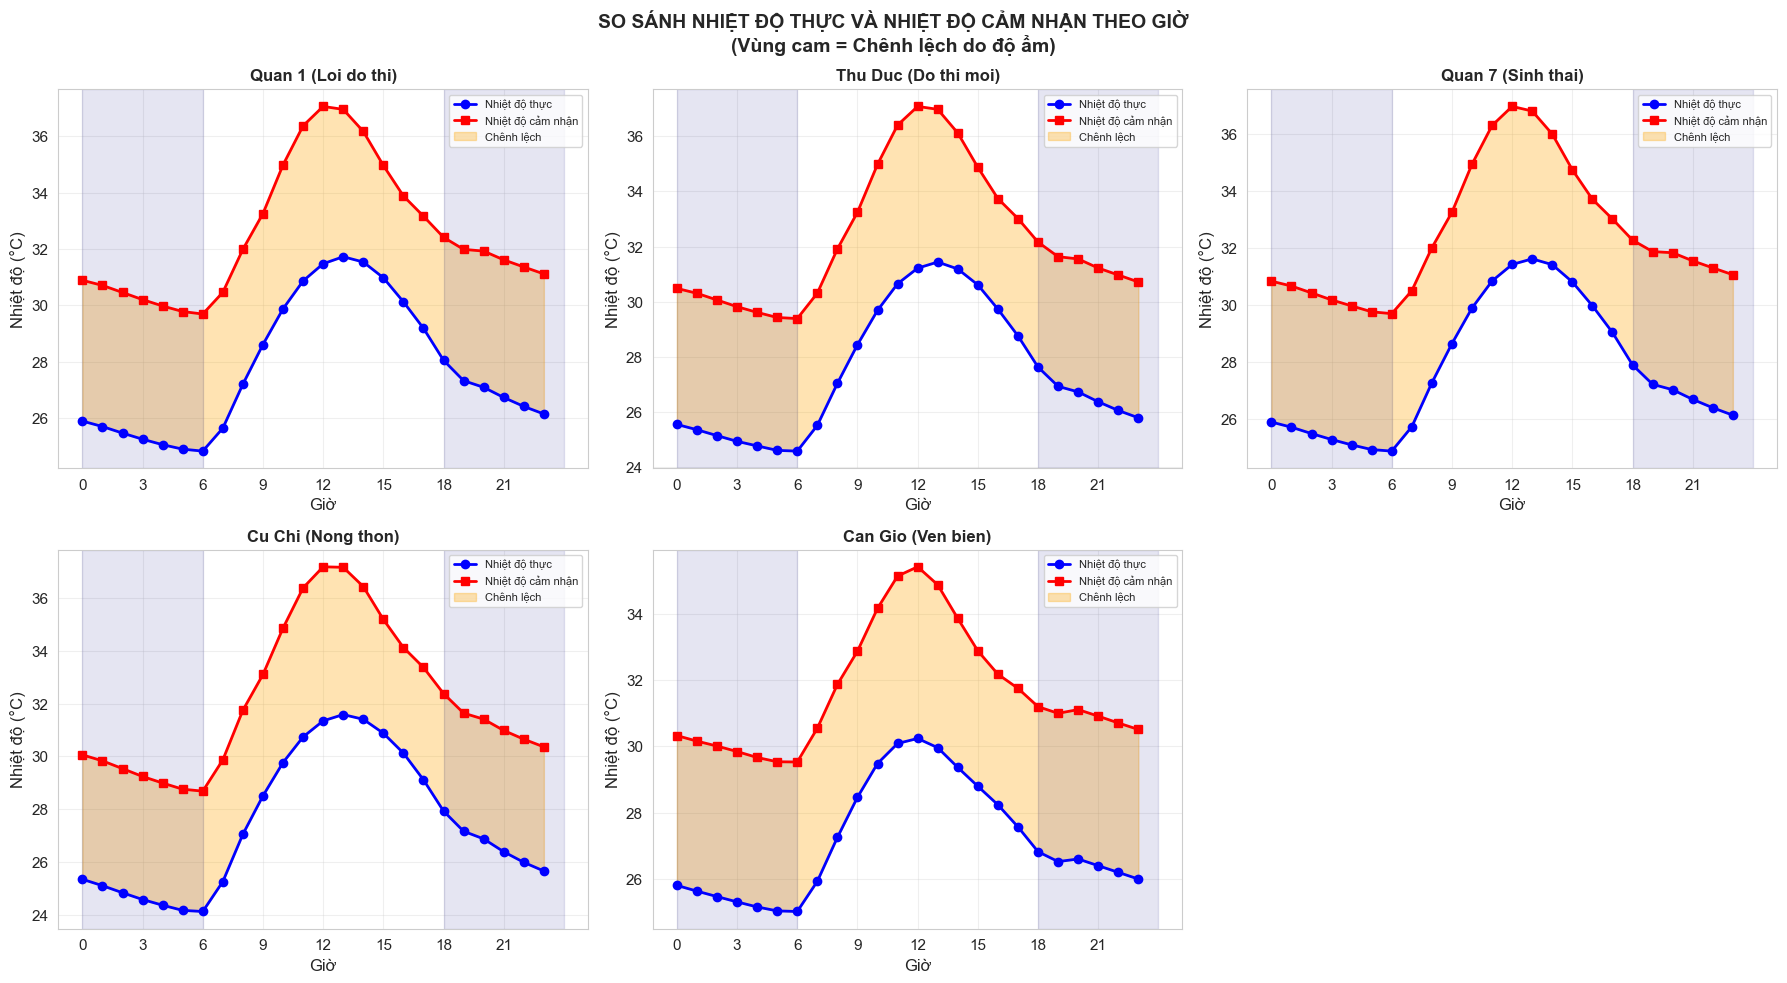


[GIẢI THÍCH]
   - Đường xanh: Nhiệt độ thực tế đo được
   - Đường đỏ: Nhiệt độ cảm nhận (Heat Index)
   - Vùng cam: Mức độ oi bức thêm do độ ẩm
   - Vùng cam RỘNG = Độ ẩm cao, cảm giác oi bức hơn nhiều so với nhiệt độ thực


In [15]:
# ========================================
# BIỂU ĐỒ 1: NHIỆT ĐỘ THỰC VS CẢM NHẬN THEO GIỜ (5 VÙNG)
# ========================================

# Tạo layout 2x3 nhưng chỉ dùng 5 ô
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, zone in enumerate(ZONE_ORDER):
    ax = axes[idx]
    df_zone = df[df['zone'] == zone]
    
    # Tính trung bình theo giờ
    temp_real = df_zone.groupby('hour')['temperature_2m'].mean()
    temp_feel = df_zone.groupby('hour')['apparent_temperature'].mean()
    
    hours = range(24)
    ax.plot(hours, temp_real, 'o-', color='blue', linewidth=2, label='Nhiệt độ thực')
    ax.plot(hours, temp_feel, 's-', color='red', linewidth=2, label='Nhiệt độ cảm nhận')
    ax.fill_between(hours, temp_real, temp_feel, alpha=0.3, color='orange', label='Chênh lệch')
    
    # Vùng ngày/đêm
    ax.axvspan(0, 6, alpha=0.1, color='navy')
    ax.axvspan(18, 24, alpha=0.1, color='navy')
    
    ax.set_title(ZONE_NAMES[zone], fontsize=12, fontweight='bold')
    ax.set_xlabel('Giờ')
    ax.set_ylabel('Nhiệt độ (°C)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 3))

# Xóa subplot thừa (thay vì chỉ tắt) để layout cân đối hơn
fig.delaxes(axes[5])

plt.suptitle('SO SÁNH NHIỆT ĐỘ THỰC VÀ NHIỆT ĐỘ CẢM NHẬN THEO GIỜ\n(Vùng cam = Chênh lệch do độ ẩm)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n[GIẢI THÍCH]")
print("   - Đường xanh: Nhiệt độ thực tế đo được")
print("   - Đường đỏ: Nhiệt độ cảm nhận (Heat Index)")
print("   - Vùng cam: Mức độ oi bức thêm do độ ẩm")
print("   - Vùng cam RỘNG = Độ ẩm cao, cảm giác oi bức hơn nhiều so với nhiệt độ thực")

## Biểu đồ 2: Chênh lệch cảm nhận theo giờ

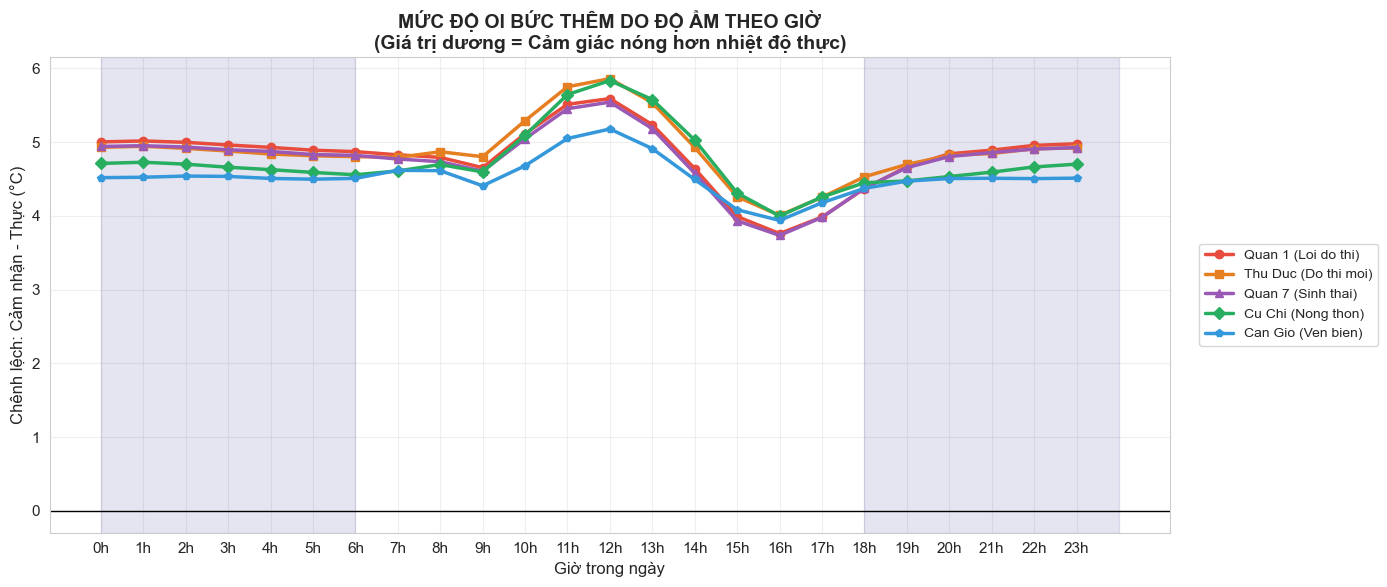


[CÁCH ĐỌC BIỂU ĐỒ]
   - Giá trị DƯƠNG: Cảm giác nóng hơn nhiệt độ thực (do độ ẩm cao)
   - Giá trị ÂM: Cảm giác mát hơn nhiệt độ thực (do gió hoặc khô ráo)
   - Đường nào NẰM CAO = Vùng đó oi bức hơn


In [16]:
# ========================================
# BIỂU ĐỒ 2: CHÊNH LỆCH (CẢM NHẬN - THỰC) THEO GIỜ - 5 VÙNG
# ========================================

# Tính cột chênh lệch TRƯỚC (Vectorization - nhanh hơn nhiều)
df['chenh_lech_cam_nhan'] = df['apparent_temperature'] - df['temperature_2m']

fig, ax = plt.subplots(figsize=(14, 6))

# Định nghĩa ký hiệu khác nhau cho mỗi vùng
ZONE_MARKERS = {
    'HCM_Center': 'o',      # Hình tròn
    'HCM_East': 's',        # Hình vuông
    'HCM_South': '^',       # Tam giác lên
    'HCM_NorthWest': 'D',   # Hình thoi
    'HCM_Coastal': 'p'      # Ngũ giác
}

for zone in ZONE_ORDER:
    df_zone = df[df['zone'] == zone]
    
    # Groupby trực tiếp trên cột mới, không dùng apply()
    diff_by_hour = df_zone.groupby('hour')['chenh_lech_cam_nhan'].mean()
    
    ax.plot(range(24), diff_by_hour, 
            marker=ZONE_MARKERS[zone],  # Ký hiệu riêng cho mỗi vùng
            color=ZONE_COLORS[zone], 
            linewidth=2.5, markersize=6, 
            label=ZONE_NAMES[zone])

# Đường mốc 0
ax.axhline(y=0, color='black', linewidth=1, linestyle='-')

# Vùng ngày/đêm
ax.axvspan(0, 6, alpha=0.1, color='navy')
ax.axvspan(18, 24, alpha=0.1, color='navy')

ax.set_xlabel('Giờ trong ngày')
ax.set_ylabel('Chênh lệch: Cảm nhận - Thực (°C)')
ax.set_title('MỨC ĐỘ OI BỨC THÊM DO ĐỘ ẨM THEO GIỜ\n(Giá trị dương = Cảm giác nóng hơn nhiệt độ thực)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h}h' for h in range(24)])

# Đưa legend ra ngoài biểu đồ (bên phải)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n[CÁCH ĐỌC BIỂU ĐỒ]")
print("   - Giá trị DƯƠNG: Cảm giác nóng hơn nhiệt độ thực (do độ ẩm cao)")
print("   - Giá trị ÂM: Cảm giác mát hơn nhiệt độ thực (do gió hoặc khô ráo)")
print("   - Đường nào NẰM CAO = Vùng đó oi bức hơn")

## Biểu đồ 3: Heatmap mức độ nguy hiểm

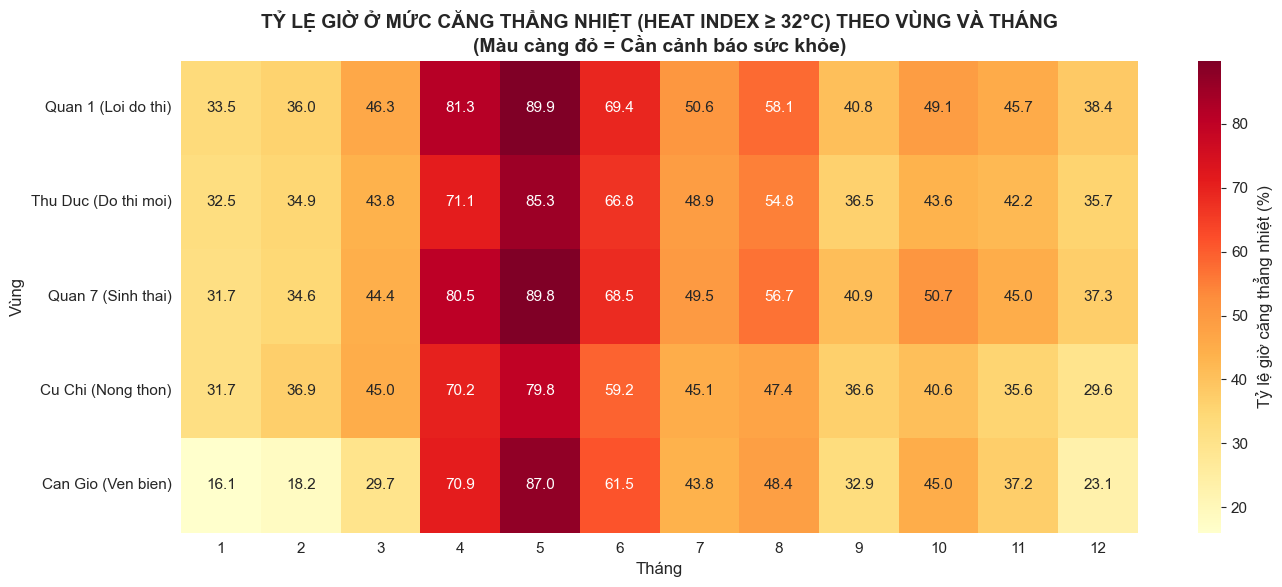


[CÁCH ĐỌC HEATMAP]
   - Số trong ô = % thời gian ở mức Đặc biệt cẩn trọng/Nguy hiểm
   - Màu VÀNG = An toàn hơn
   - Màu ĐỎ ĐẬM = Căng thẳng nhiệt cao, cần cảnh báo sức khỏe
   - Hàng nào đỏ đậm nhất = Vùng cần quan tâm nhất


In [17]:
# ========================================
# BIỂU ĐỒ 3: HEATMAP - TỶ LỆ GIỜ CĂNG THẲNG NHIỆT THEO VÙNG VÀ THÁNG
# ========================================

# Tính tỷ lệ giờ ở mức "Đặc biệt cẩn trọng" hoặc "Nguy hiểm" theo vùng và tháng
df['cang_thang_nhiet'] = df['muc_do_nhiet'].isin([
    'Đặc biệt cẩn trọng (32-41°C)', 
    'Nguy hiểm (>41°C)'
]).astype(int)

# Pivot table
heatmap_data = df.pivot_table(
    values='cang_thang_nhiet', 
    index='zone', 
    columns='month', 
    aggfunc='mean'
) * 100  # Chuyển sang %

# Đổi tên index
heatmap_data.index = heatmap_data.index.map(ZONE_NAMES)

# Sắp xếp lại theo ZONE_ORDER
zone_names_order = [ZONE_NAMES[z] for z in ZONE_ORDER]
heatmap_data = heatmap_data.reindex(zone_names_order)

# Vẽ heatmap
fig, ax = plt.subplots(figsize=(14, 6))

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Tỷ lệ giờ căng thẳng nhiệt (%)'}, ax=ax)

ax.set_xlabel('Tháng')
ax.set_ylabel('Vùng')
ax.set_title('TỶ LỆ GIỜ Ở MỨC CĂNG THẲNG NHIỆT (HEAT INDEX ≥ 32°C) THEO VÙNG VÀ THÁNG\n(Màu càng đỏ = Cần cảnh báo sức khỏe)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n[CÁCH ĐỌC HEATMAP]")
print("   - Số trong ô = % thời gian ở mức Đặc biệt cẩn trọng/Nguy hiểm")
print("   - Màu VÀNG = An toàn hơn")
print("   - Màu ĐỎ ĐẬM = Căng thẳng nhiệt cao, cần cảnh báo sức khỏe")
print("   - Hàng nào đỏ đậm nhất = Vùng cần quan tâm nhất")

## Biểu đồ 4: Boxplot

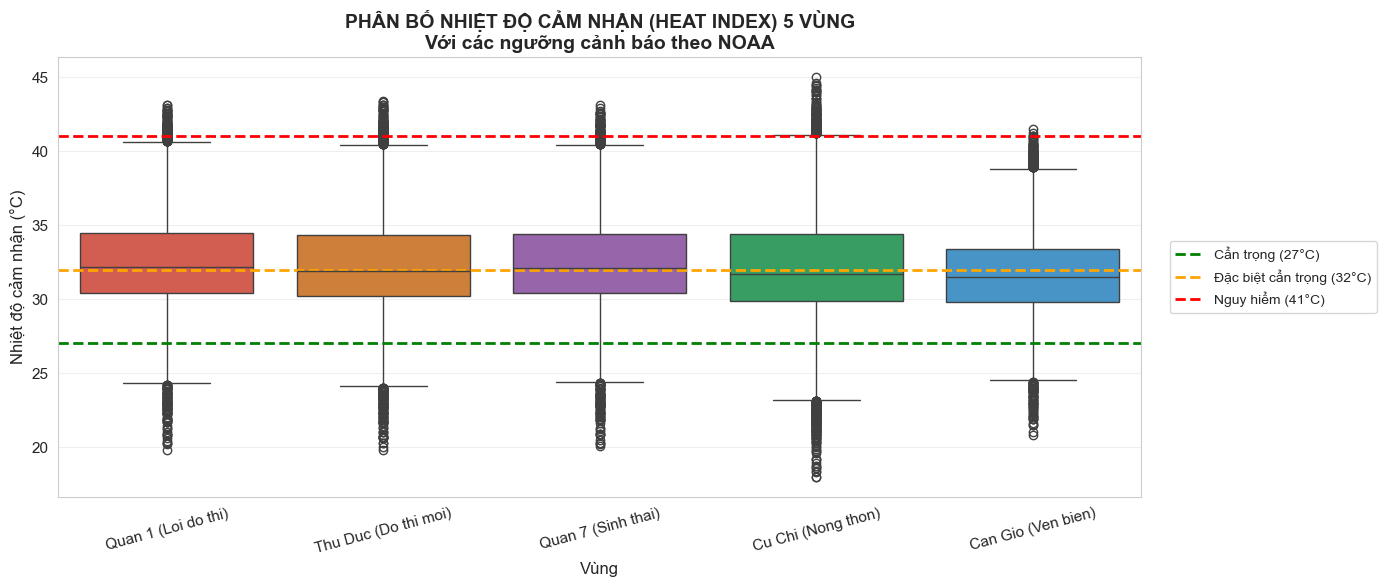


[NHẬN XÉT]
   - Box nằm càng CAO = Vùng đó cảm giác nóng bức hơn
   - Box nào vượt qua đường CAM (32°C) = Có nhiều giờ cần Đặc biệt cẩn trọng
   - Whisker (râu) dài = Biến động nhiệt độ cảm nhận lớn


In [18]:
# ========================================
# BIỂU ĐỒ 4: BOXPLOT - NHIỆT ĐỘ CẢM NHẬN 5 VÙNG
# ========================================

fig, ax = plt.subplots(figsize=(14, 6))

# Tạo palette màu
palette = {ZONE_NAMES[z]: ZONE_COLORS[z] for z in ZONE_ORDER}

# Thêm cột tên vùng tiếng Việt
df['ten_vung'] = df['zone'].map(ZONE_NAMES)

# Vẽ boxplot
order = [ZONE_NAMES[z] for z in ZONE_ORDER]
sns.boxplot(data=df, x='ten_vung', y='apparent_temperature', order=order, palette=palette, ax=ax)

# Thêm đường ngưỡng theo chuẩn NOAA (đã điều chỉnh)
ax.axhline(y=27, color='green', linestyle='--', linewidth=2, label='Cẩn trọng (27°C)')
ax.axhline(y=32, color='orange', linestyle='--', linewidth=2, label='Đặc biệt cẩn trọng (32°C)')
ax.axhline(y=41, color='red', linestyle='--', linewidth=2, label='Nguy hiểm (41°C)')

ax.set_xlabel('Vùng')
ax.set_ylabel('Nhiệt độ cảm nhận (°C)')
ax.set_title('PHÂN BỐ NHIỆT ĐỘ CẢM NHẬN (HEAT INDEX) 5 VÙNG\nVới các ngưỡng cảnh báo theo NOAA', 
             fontsize=14, fontweight='bold')

# Đưa legend ra ngoài biểu đồ (bên phải)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10)

ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print("\n[NHẬN XÉT]")
print("   - Box nằm càng CAO = Vùng đó cảm giác nóng bức hơn")
print("   - Box nào vượt qua đường CAM (32°C) = Có nhiều giờ cần Đặc biệt cẩn trọng")
print("   - Whisker (râu) dài = Biến động nhiệt độ cảm nhận lớn")

## Biểu đồ 5: Scatter Plot tương quan

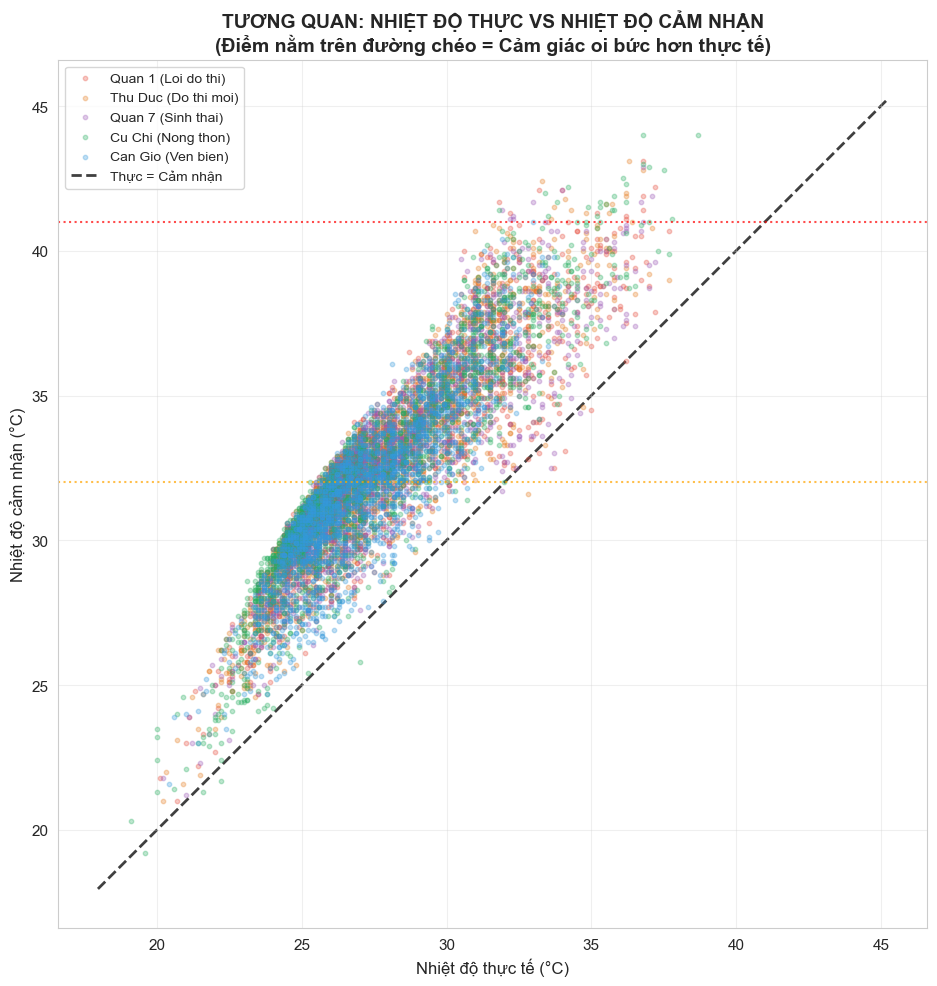


[CÁCH ĐỌC SCATTER PLOT]
   - Đường chéo đen: Điểm chuẩn (Nhiệt độ thực = Cảm nhận)
   - Các điểm nằm TRÊN đường chéo: Cảm giác nóng hơn thực tế (do độ ẩm cao)
   - Các điểm nằm DƯỚI đường chéo: Cảm giác mát hơn thực tế (do gió/khô)
   - Vùng nào có đám mây điểm nằm CAO nhất so với đường chéo = Vùng oi bức nhất
   - Đường cam ngang: Ngưỡng Đặc biệt cẩn trọng (32°C)
   - Đường đỏ ngang: Ngưỡng Nguy hiểm (41°C)


In [19]:
# ========================================
# BIỂU ĐỒ 5: SCATTER PLOT - TƯƠNG QUAN NHIỆT ĐỘ THỰC VS CẢM NHẬN
# ========================================

fig, ax = plt.subplots(figsize=(10, 10))

for zone in ZONE_ORDER:
    df_zone = df[df['zone'] == zone]
    
    # Lấy mẫu ngẫu nhiên 2000 điểm để vẽ (tránh quá nhiều điểm gây rối)
    sample_size = min(2000, len(df_zone))
    df_sample = df_zone.sample(sample_size, random_state=42)
    
    ax.scatter(df_sample['temperature_2m'], df_sample['apparent_temperature'], 
               alpha=0.3, label=ZONE_NAMES[zone], color=ZONE_COLORS[zone], s=10)

# Đường chuẩn y=x (Nhiệt độ thực = Cảm nhận)
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1]),
]
ax.plot(lims, lims, 'k--', alpha=0.75, linewidth=2, zorder=0, label="Thực = Cảm nhận")

# Đường ngưỡng cảnh báo
ax.axhline(y=32, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax.axhline(y=41, color='red', linestyle=':', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Nhiệt độ thực tế (°C)', fontsize=12)
ax.set_ylabel('Nhiệt độ cảm nhận (°C)', fontsize=12)
ax.set_title('TƯƠNG QUAN: NHIỆT ĐỘ THỰC VS NHIỆT ĐỘ CẢM NHẬN\n(Điểm nằm trên đường chéo = Cảm giác oi bức hơn thực tế)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Đảm bảo tỷ lệ 1:1
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print("\n[CÁCH ĐỌC SCATTER PLOT]")
print("   - Đường chéo đen: Điểm chuẩn (Nhiệt độ thực = Cảm nhận)")
print("   - Các điểm nằm TRÊN đường chéo: Cảm giác nóng hơn thực tế (do độ ẩm cao)")
print("   - Các điểm nằm DƯỚI đường chéo: Cảm giác mát hơn thực tế (do gió/khô)")
print("   - Vùng nào có đám mây điểm nằm CAO nhất so với đường chéo = Vùng oi bức nhất")
print("   - Đường cam ngang: Ngưỡng Đặc biệt cẩn trọng (32°C)")
print("   - Đường đỏ ngang: Ngưỡng Nguy hiểm (41°C)")

##  Kết luận cho Câu hỏi 3
**"Chỉ số nóng bức thực tế (Heat Index) - Vùng nào đáng sợ nhất?"**

---

### 1. Bảng so sánh nhiệt độ thực vs cảm nhận (5 vùng)

| Vùng | Nhiệt độ thực (°C) | Độ ẩm TB (%) | Nhiệt độ cảm nhận (°C) | Oi bức thêm (°C) | Max cảm nhận (°C) |
|------|-------------------|--------------|------------------------|------------------|-------------------|
| Quận 1 (Lõi đô thị) | 27.75 | 78.47 | **32.56** | +4.81 | 43.10 |
| Thủ Đức (Đô thị mới) | 27.46 | 79.58 | 32.34 | +4.88 | 43.40 |
| Quận 7 (Sinh thái) | 27.71 | 78.67 | 32.48 | +4.76 | 43.10 |
| Củ Chi (Nông thôn) | 27.43 | 79.10 | 32.16 | +4.73 | **45.00** |
| Cần Giờ (Ven biển) | **27.14** | **82.18** | **31.66** | +4.53 | 41.50 |

**Phát hiện quan trọng:**
- **Quận 1** có nhiệt độ cảm nhận trung bình **cao nhất** (32.56°C) → Vùng oi bức nhất
- **Cần Giờ** có nhiệt độ thực **thấp nhất** (27.14°C) nhưng độ ẩm **cao nhất** (82.18%) → Nghịch lý "mát nhưng oi"
- **Củ Chi** có max cảm nhận **cao nhất** (45.00°C) → Những ngày cực đoan nguy hiểm nhất
- Tất cả 5 vùng đều có mức oi bức thêm từ **+4.5°C đến +4.9°C** do độ ẩm

---

### 2. Phân tích theo giờ trong ngày (Biểu đồ 1 & 2)

**Quan sát từ biểu đồ nhiệt độ thực vs cảm nhận:**
- Vùng cam (chênh lệch) **rộng nhất** vào khoảng **10h-14h** (giữa trưa nắng nóng)
- Tất cả 5 vùng đều có pattern tương tự: chênh lệch tăng khi nhiệt độ tăng
- **Củ Chi** có vùng cam lớn nhất vào giữa trưa, cho thấy độ ẩm vẫn cao dù là vùng nông thôn

**Quan sát từ biểu đồ mức độ oi bức theo giờ:**
- Chênh lệch cảm nhận dao động từ **+3.7°C đến +5.9°C** tùy giờ
- **Đỉnh oi bức** xảy ra lúc **11h-13h** với chênh lệch lên đến **+5.5°C đến +5.9°C**
- **Thấp nhất** vào lúc **16h-17h** (~+3.7°C đến +4.2°C)
- **Củ Chi** (xanh lá) có đỉnh oi bức cao nhất (~+5.9°C lúc 12h-13h)
- **Cần Giờ** (xanh dương) nằm thấp nhất suốt ngày, ít oi bức nhất

---

### 3. Tỷ lệ thời gian ở mức căng thẳng nhiệt (Heatmap)

**Phân tích theo tháng:**

| Tháng | Đặc điểm | Vùng nguy hiểm nhất | Tỷ lệ (%) |
|-------|----------|---------------------|-----------|
| **Tháng 5** | Nóng nhất năm | Quận 7 | **89.8%** |
| Tháng 4 | Đầu mùa nóng | Quận 1 | 81.3% |
| Tháng 6 | Mùa mưa bắt đầu | Quận 1 | 69.4% |
| Tháng 1-2 | Mùa khô mát | Cần Giờ | ~16-18% |

**Phân tích theo vùng:**
- **Quận 7** có tỷ lệ căng thẳng nhiệt **cao nhất** vào tháng 5 (89.8%)
- **Quận 1** có tỷ lệ cao đều đặn quanh năm (33-90%)
- **Cần Giờ** an toàn nhất vào mùa khô (tháng 1-2 chỉ ~16-18%)
- **Tháng 5** là tháng nguy hiểm nhất cho TẤT CẢ các vùng (70-90%)

---

### 4. Phân bố Heat Index (Boxplot)

**Quan sát từ boxplot:**
- Tất cả 5 vùng có **median nằm trên ngưỡng 32°C** (đường cam) → Thường xuyên ở mức "Đặc biệt cẩn trọng"
- **Quận 1, Thủ Đức, Quận 7** có box cao nhất và tương đương nhau
- **Cần Giờ** có box thấp nhất, ít vượt ngưỡng nguy hiểm nhất
- **Củ Chi** có whisker (râu) dài nhất, biến động nhiệt độ cảm nhận lớn nhất (có thể lên 45°C)
- Có một số outliers vượt ngưỡng **41°C (Nguy hiểm)** ở tất cả các vùng

---

### 5. Tương quan Nhiệt độ thực vs Cảm nhận (Scatter Plot)

**Phát hiện từ scatter plot:**
- **100% các điểm nằm TRÊN đường chéo** → Tất cả các vùng đều cảm giác nóng hơn thực tế
- Khoảng cách từ đám mây điểm đến đường chéo **tăng dần** khi nhiệt độ tăng
- Nhiều điểm vượt qua ngưỡng **32°C** (đường cam) và một số vượt **41°C** (đường đỏ)
- **Cần Giờ** (xanh dương) có đám mây điểm nằm **thấp nhất** → Ít oi bức nhất
- **Củ Chi** (xanh lá) có một số điểm cao nhất (~45°C) → Những ngày cực đoan

---

### 6. Nghịch lý "Mát nhưng Oi bức"

**Trường hợp Cần Giờ:**
- Nhiệt độ thực: **27.14°C** (thấp nhất trong 5 vùng)
- Độ ẩm: **82.18%** (cao nhất trong 5 vùng)
- Nhiệt độ cảm nhận: **31.66°C** (vẫn ở mức Cẩn trọng)
- Oi bức thêm: **+4.53°C**

> **Kết luận:** Mặc dù Cần Giờ "mát" nhất về nhiệt độ thực, nhưng độ ẩm cao vẫn gây cảm giác **oi bức và khó chịu**. Tuy nhiên, so với các vùng khác, Cần Giờ vẫn là nơi **dễ chịu nhất** về Heat Index.

---

### 7. Trả lời câu hỏi nghiên cứu

**"Vùng nào đáng sợ nhất về chỉ số nóng bức thực tế?"**

> **Quận 1 (Lõi đô thị)** là vùng có Heat Index trung bình **cao nhất** (32.56°C), kết hợp giữa nhiệt độ cao (27.75°C) và độ ẩm tương đối cao (78.47%). Đây là vùng cần **ưu tiên cảnh báo sức khỏe**.

**"Tháng nào nguy hiểm nhất?"**

> **Tháng 5** là tháng nguy hiểm nhất với tỷ lệ thời gian ở mức căng thẳng nhiệt lên đến **85-90%** ở tất cả các vùng đô thị.

**"Có nghịch lý 'mát nhưng oi' không?"**

> **Có**, nhưng không rõ rệt như kỳ vọng. Cần Giờ có độ ẩm cao nhất (82%) nhưng vẫn là vùng **dễ chịu nhất** do nhiệt độ thực thấp. Nghịch lý rõ hơn ở **Thủ Đức** với độ ẩm cao (79.58%) nhưng mức oi bức thêm lớn nhất (+4.88°C).

---

### 8. Ý nghĩa thực tiễn

1. **Cảnh báo sức khỏe:**
   - Nên dựa trên **Heat Index** thay vì chỉ nhiệt độ không khí
   - Ưu tiên cảnh báo cho **Quận 1, Thủ Đức, Quận 7** (các vùng đô thị)
   - Tháng 4-5-6 là giai đoạn cần cảnh báo **tăng cường**

2. **Hoạt động ngoài trời:**
   - Tránh hoạt động từ **10h-14h** (đỉnh oi bức)
   - Nếu phải làm việc ngoài trời, ưu tiên **Cần Giờ** (mát nhất)
   - **Củ Chi** có biến động lớn, có thể cực kỳ nguy hiểm vào những ngày nóng đỉnh điểm

3. **Năng lượng:**
   - Nhu cầu điều hòa không khí tại **Quận 1** cao nhất do Heat Index cao liên tục
   - Tháng 5 là tháng tiêu thụ điện **cao điểm** cho máy lạnh

4. **Quy hoạch đô thị:**
   - Tăng cây xanh, mặt nước tại **Quận 1, Thủ Đức** để giảm Heat Index
   - Bảo tồn hệ sinh thái **Cần Giờ** như "máy điều hòa tự nhiên" của TP.HCM

# Câu hỏi 4: Khung giờ nguy hiểm và thời gian "hạ nhiệt" sau hoàng hôn khác nhau thế nào?

## 1. Nội dung câu hỏi
Xác định:
- **Thời điểm nhiệt độ đạt đỉnh** (Peak Temperature) trong ngày tại mỗi vùng
- **Thời gian cần thiết** để nhiệt độ giảm về mức dễ chịu (<28°C) sau khi mặt trời lặn (18h)
- Sự khác biệt về **"quán tính nhiệt"** (thermal inertia) giữa các vùng

## 2. Lợi ích của việc tìm ra câu trả lời
- Giúp người lao động ngoài trời (công nhân xây dựng, shipper, nông dân) **sắp xếp lịch làm việc** tránh giờ nguy hiểm nhất
- Cung cấp thông tin cho các đơn vị **tổ chức sự kiện ngoài trời**
- Đánh giá **khả năng tản nhiệt** của từng vùng - phản ánh mức độ đô thị hóa

## 3. Kỳ vọng kết quả
- **Củ Chi (Nông thôn):** Đạt đỉnh sớm (12h-13h), giảm nhanh sau khi tắt nắng
- **Quận 1, Thủ Đức (Đô thị):** Đạt đỉnh muộn (14h-15h), giảm rất chậm do bê tông giữ nhiệt
- **Cần Giờ (Ven biển):** Biên độ ngày-đêm nhỏ do ảnh hưởng điều hòa của biển

## 4. Khái niệm quan trọng
- **Thermal Inertia (Quán tính nhiệt):** Khả năng của một vật liệu chống lại sự thay đổi nhiệt độ. Bê tông có quán tính nhiệt cao → giữ nhiệt lâu, tỏa nhiệt chậm.
- **Thermal Decay (Suy giảm nhiệt):** Tốc độ giảm nhiệt độ sau khi mất nguồn nhiệt (mặt trời lặn).

### Xác định khung giờ đạt đỉnh

In [20]:
# ========================================
# CÂU HỎI 4: KHUNG GIỜ NGUY HIỂM VÀ THỜI GIAN HẠ NHIỆT
# ========================================

print("=" * 70)
print("PHÂN TÍCH KHUNG GIỜ ĐẠT ĐỈNH NHIỆT ĐỘ TẠI 5 VÙNG")
print("=" * 70)

# Tính nhiệt độ trung bình theo giờ cho từng vùng
ket_qua_dinh = []

for zone in ZONE_ORDER:
    df_zone = df[df['zone'] == zone]
    temp_by_hour = df_zone.groupby('hour')['temperature_2m'].mean()
    
    # Tìm giờ đạt đỉnh
    gio_dinh = temp_by_hour.idxmax()
    nhiet_do_dinh = temp_by_hour.max()
    
    # Tìm giờ thấp nhất
    gio_thap = temp_by_hour.idxmin()
    nhiet_do_thap = temp_by_hour.min()
    
    # Biên độ của biểu đồ trung bình (không phải DTR chuẩn)
    bien_do_tb = nhiet_do_dinh - nhiet_do_thap
    
    # Tính DTR chuẩn: Trung bình của (Max - Min) từng ngày
    df_zone_copy = df_zone.copy()
    df_zone_copy['date'] = df_zone_copy['time'].dt.date
    dtr_chuan = df_zone_copy.groupby('date')['temperature_2m'].apply(
        lambda x: x.max() - x.min()
    ).mean()
    
    ket_qua_dinh.append({
        'Vùng': ZONE_NAMES[zone],
        'Giờ đỉnh': f"{gio_dinh}h",
        'Nhiệt độ đỉnh (°C)': round(nhiet_do_dinh, 2),
        'Giờ thấp nhất': f"{gio_thap}h",
        'Nhiệt độ thấp (°C)': round(nhiet_do_thap, 2),
        'Biên độ TB (°C)': round(bien_do_tb, 2),
        'DTR chuẩn (°C)': round(dtr_chuan, 2)
    })

df_dinh = pd.DataFrame(ket_qua_dinh)
print("\n[THỐNG KÊ GIỜ ĐẠT ĐỈNH VÀ BIÊN ĐỘ NHIỆT ĐỘ]")
print(df_dinh.to_string(index=False))

print("\n[GHI CHÚ THUẬT NGỮ]")
print("   - Biên độ TB: Max(Mean theo giờ) - Min(Mean theo giờ) → Biên độ của đường trung bình")
print("   - DTR chuẩn: Mean(Max ngày - Min ngày) → Diurnal Temperature Range thực tế")

# Nhận xét
print("\n[NHẬN XÉT]")
gio_dinh_list = [int(r['Giờ đỉnh'].replace('h', '')) for r in ket_qua_dinh]
if max(gio_dinh_list) - min(gio_dinh_list) == 0:
    print(f"   - Tất cả 5 vùng đều đạt đỉnh cùng lúc: {gio_dinh_list[0]}h")
else:
    print(f"   - Giờ đạt đỉnh sớm nhất: {min(gio_dinh_list)}h")
    print(f"   - Giờ đạt đỉnh muộn nhất: {max(gio_dinh_list)}h")

dtr_max = df_dinh['DTR chuẩn (°C)'].max()
vung_dtr_lon = df_dinh.loc[df_dinh['DTR chuẩn (°C)'].idxmax(), 'Vùng']
dtr_min = df_dinh['DTR chuẩn (°C)'].min()
vung_dtr_nho = df_dinh.loc[df_dinh['DTR chuẩn (°C)'].idxmin(), 'Vùng']

print(f"   - DTR lớn nhất: {vung_dtr_lon} ({dtr_max}°C) → Biến động nhiệt độ ngày-đêm mạnh")
print(f"   - DTR nhỏ nhất: {vung_dtr_nho} ({dtr_min}°C) → Nhiệt độ ổn định hơn")

PHÂN TÍCH KHUNG GIỜ ĐẠT ĐỈNH NHIỆT ĐỘ TẠI 5 VÙNG

[THỐNG KÊ GIỜ ĐẠT ĐỈNH VÀ BIÊN ĐỘ NHIỆT ĐỘ]
                Vùng Giờ đỉnh  Nhiệt độ đỉnh (°C) Giờ thấp nhất  Nhiệt độ thấp (°C)  Biên độ TB (°C)  DTR chuẩn (°C)
 Quan 1 (Loi do thi)      13h               31.72            6h               24.82             6.91            7.66
Thu Duc (Do thi moi)      13h               31.44            6h               24.59             6.85            7.61
  Quan 7 (Sinh thai)      13h               31.61            6h               24.87             6.74            7.54
  Cu Chi (Nong thon)      13h               31.58            6h               24.13             7.46            8.20
  Can Gio (Ven bien)      12h               30.23            6h               25.02             5.22            5.91

[GHI CHÚ THUẬT NGỮ]
   - Biên độ TB: Max(Mean theo giờ) - Min(Mean theo giờ) → Biên độ của đường trung bình
   - DTR chuẩn: Mean(Max ngày - Min ngày) → Diurnal Temperature Range thực tế

[NHẬN XÉT]
   - 

### Phân tích thời gian hạ nhiệt

In [21]:
# ========================================
# PHÂN TÍCH THỜI GIAN HẠ NHIỆT SAU HOÀNG HÔN (18h)
# ========================================

print("=" * 70)
print("PHÂN TÍCH THỜI GIAN HẠ NHIỆT SAU 18h (HOÀNG HÔN)")
print("=" * 70)

print("\n[LƯU Ý PHƯƠNG PHÁP]")
print("   Phân tích dựa trên NHIỆT ĐỘ TRUNG BÌNH theo giờ (2 năm dữ liệu).")
print("   Kết quả phản ánh xu hướng chung, không phải từng đêm cụ thể.")
print("   Thực tế: Mùa mưa có thể mát từ 18h, mùa khô có thể nóng đến 2h sáng.")

# Ngưỡng nhiệt độ "dễ chịu"
NGUONG_DE_CHIU = 28.0

# Tính nhiệt độ trung bình theo giờ đêm cho từng vùng
ket_qua_ha_nhiet = []

for zone in ZONE_ORDER:
    df_zone = df[df['zone'] == zone]
    temp_by_hour = df_zone.groupby('hour')['temperature_2m'].mean()
    
    # Nhiệt độ lúc 18h
    temp_18h = temp_by_hour[18]
    
    # Tìm giờ đầu tiên nhiệt độ giảm xuống dưới ngưỡng
    gio_dat_nguong = None
    for h in list(range(18, 24)) + list(range(0, 7)):
        if temp_by_hour[h] < NGUONG_DE_CHIU:
            gio_dat_nguong = h
            break
    
    # Tính thời gian hạ nhiệt
    if gio_dat_nguong is not None:
        if gio_dat_nguong >= 18:
            thoi_gian = gio_dat_nguong - 18
        else:
            thoi_gian = (24 - 18) + gio_dat_nguong
        thoi_gian_str = f"{thoi_gian} giờ"
    else:
        thoi_gian = None
        thoi_gian_str = "Không đạt"
    
    # Nhiệt độ lúc 6h sáng
    temp_6h = temp_by_hour[6]
    
    # Độ giảm từ 18h đến 6h
    do_giam = temp_18h - temp_6h
    
    ket_qua_ha_nhiet.append({
        'Vùng': ZONE_NAMES[zone],
        'Nhiệt độ 18h (°C)': round(temp_18h, 2),
        'Giờ đạt <28°C': f"{gio_dat_nguong}h" if gio_dat_nguong else "Không đạt",
        'Thời gian hạ nhiệt': thoi_gian_str,
        'Nhiệt độ 6h (°C)': round(temp_6h, 2),
        'Độ giảm qua đêm (°C)': round(do_giam, 2)
    })

df_ha_nhiet = pd.DataFrame(ket_qua_ha_nhiet)
print(f"\n[THỜI GIAN HẠ NHIỆT VỀ MỨC DỄ CHỊU (<{NGUONG_DE_CHIU}°C) - DỰA TRÊN TRUNG BÌNH]")
print(df_ha_nhiet.to_string(index=False))

# Nhận xét
print("\n[NHẬN XÉT]")
# Vùng hạ nhiệt nhanh nhất
vung_nhanh = df_ha_nhiet.loc[df_ha_nhiet['Độ giảm qua đêm (°C)'].idxmax()]
vung_cham = df_ha_nhiet.loc[df_ha_nhiet['Độ giảm qua đêm (°C)'].idxmin()]

print(f"   - Vùng hạ nhiệt NHANH nhất: {vung_nhanh['Vùng']} (giảm {vung_nhanh['Độ giảm qua đêm (°C)']}°C qua đêm)")
print(f"      → Nguyên nhân: Bề mặt tự nhiên (đất, cây xanh) tản nhiệt nhanh")

print(f"\n   - Vùng hạ nhiệt CHẬM nhất: {vung_cham['Vùng']} (chỉ giảm {vung_cham['Độ giảm qua đêm (°C)']}°C qua đêm)")
print(f"      → Nguyên nhân: QUÁN TÍNH NHIỆT (Thermal Inertia) lớn của bê tông đô thị")
print(f"      → Bê tông hấp thụ nhiệt ban ngày và giải phóng từ từ vào ban đêm")

PHÂN TÍCH THỜI GIAN HẠ NHIỆT SAU 18h (HOÀNG HÔN)

[LƯU Ý PHƯƠNG PHÁP]
   Phân tích dựa trên NHIỆT ĐỘ TRUNG BÌNH theo giờ (2 năm dữ liệu).
   Kết quả phản ánh xu hướng chung, không phải từng đêm cụ thể.
   Thực tế: Mùa mưa có thể mát từ 18h, mùa khô có thể nóng đến 2h sáng.

[THỜI GIAN HẠ NHIỆT VỀ MỨC DỄ CHỊU (<28.0°C) - DỰA TRÊN TRUNG BÌNH]
                Vùng  Nhiệt độ 18h (°C) Giờ đạt <28°C Thời gian hạ nhiệt  Nhiệt độ 6h (°C)  Độ giảm qua đêm (°C)
 Quan 1 (Loi do thi)              28.04           19h              1 giờ             24.82                  3.23
Thu Duc (Do thi moi)              27.64           18h              0 giờ             24.59                  3.04
  Quan 7 (Sinh thai)              27.89           18h              0 giờ             24.87                  3.02
  Cu Chi (Nong thon)              27.93           18h              0 giờ             24.13                  3.80
  Can Gio (Ven bien)              26.82           18h              0 giờ             25.02  

### Biểu đồ 1: Đường cong nhiệt độ 24 h

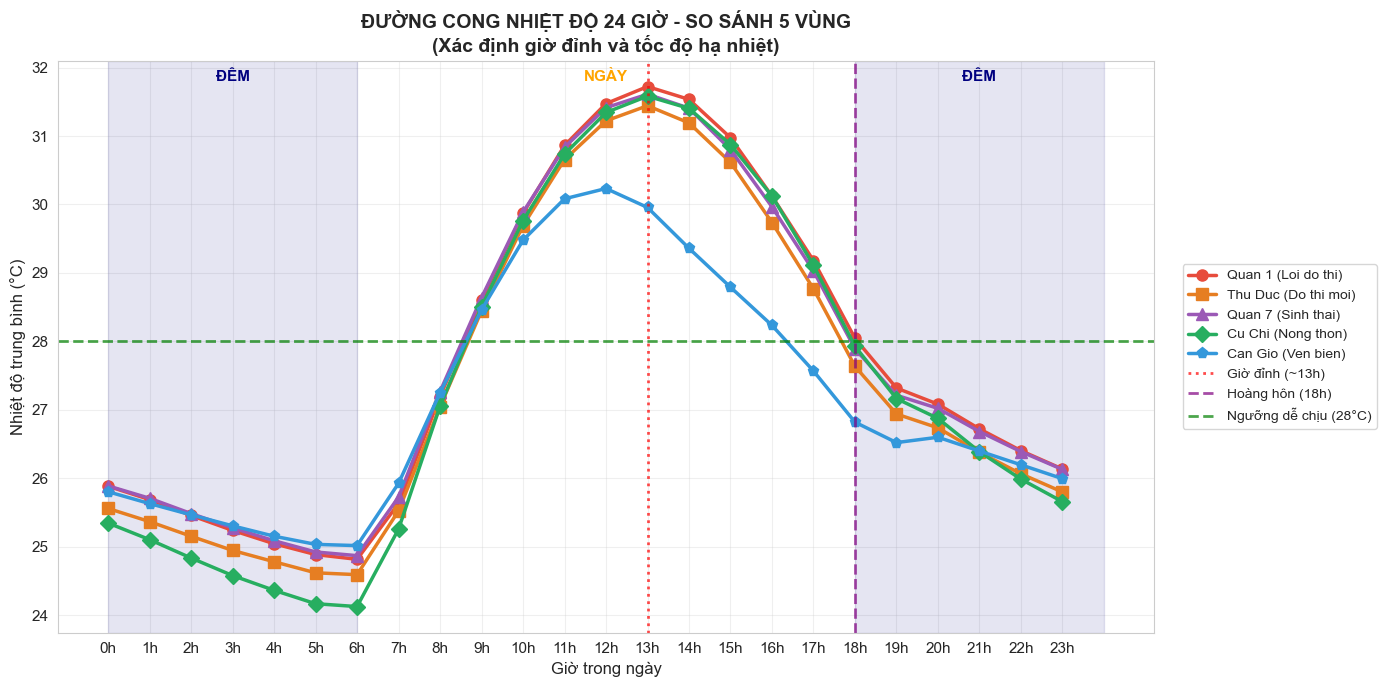


[CÁCH ĐỌC BIỂU ĐỒ]
   - Đường đỏ chấm: Giờ đạt đỉnh nhiệt độ (~13h)
   - Đường tím đứt: Hoàng hôn (18h) - bắt đầu hạ nhiệt
   - Đường xanh lá đứt: Ngưỡng dễ chịu (28°C)
   - Đường nào dốc XUỐNG nhanh sau 18h = Vùng hạ nhiệt nhanh


In [22]:
# ========================================
# BIỂU ĐỒ 1: ĐƯỜNG CONG NHIỆT ĐỘ 24 GIỜ (5 VÙNG)
# ========================================

# Định nghĩa ký hiệu khác nhau cho mỗi vùng
ZONE_MARKERS = {
    'HCM_Center': 'o',      # Hình tròn
    'HCM_East': 's',        # Hình vuông
    'HCM_South': '^',       # Tam giác lên
    'HCM_NorthWest': 'D',   # Hình thoi
    'HCM_Coastal': 'p'      # Ngũ giác
}

fig, ax = plt.subplots(figsize=(14, 7))

for zone in ZONE_ORDER:
    df_zone = df[df['zone'] == zone]
    temp_by_hour = df_zone.groupby('hour')['temperature_2m'].mean()
    
    ax.plot(range(24), temp_by_hour, 
            marker=ZONE_MARKERS[zone],
            color=ZONE_COLORS[zone], 
            linewidth=2.5, markersize=8, 
            label=ZONE_NAMES[zone])

# Đánh dấu các mốc quan trọng
ax.axvline(x=13, color='red', linestyle=':', linewidth=2, alpha=0.7, label='Giờ đỉnh (~13h)')
ax.axvline(x=18, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Hoàng hôn (18h)')
ax.axhline(y=28, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Ngưỡng dễ chịu (28°C)')

# Vùng ngày/đêm
ax.axvspan(0, 6, alpha=0.1, color='navy')
ax.axvspan(18, 24, alpha=0.1, color='navy')

# Chú thích vùng ngày/đêm
ax.text(3, ax.get_ylim()[1]-0.3, 'ĐÊM', fontsize=11, ha='center', color='navy', fontweight='bold')
ax.text(12, ax.get_ylim()[1]-0.3, 'NGÀY', fontsize=11, ha='center', color='orange', fontweight='bold')
ax.text(21, ax.get_ylim()[1]-0.3, 'ĐÊM', fontsize=11, ha='center', color='navy', fontweight='bold')

ax.set_xlabel('Giờ trong ngày', fontsize=12)
ax.set_ylabel('Nhiệt độ trung bình (°C)', fontsize=12)
ax.set_title('ĐƯỜNG CONG NHIỆT ĐỘ 24 GIỜ - SO SÁNH 5 VÙNG\n(Xác định giờ đỉnh và tốc độ hạ nhiệt)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h}h' for h in range(24)])

# Legend ra ngoài
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n[CÁCH ĐỌC BIỂU ĐỒ]")
print("   - Đường đỏ chấm: Giờ đạt đỉnh nhiệt độ (~13h)")
print("   - Đường tím đứt: Hoàng hôn (18h) - bắt đầu hạ nhiệt")
print("   - Đường xanh lá đứt: Ngưỡng dễ chịu (28°C)")
print("   - Đường nào dốc XUỐNG nhanh sau 18h = Vùng hạ nhiệt nhanh")

### Biểu đồ 2: Đường cong hạ nhiệt sau hoàng hôn

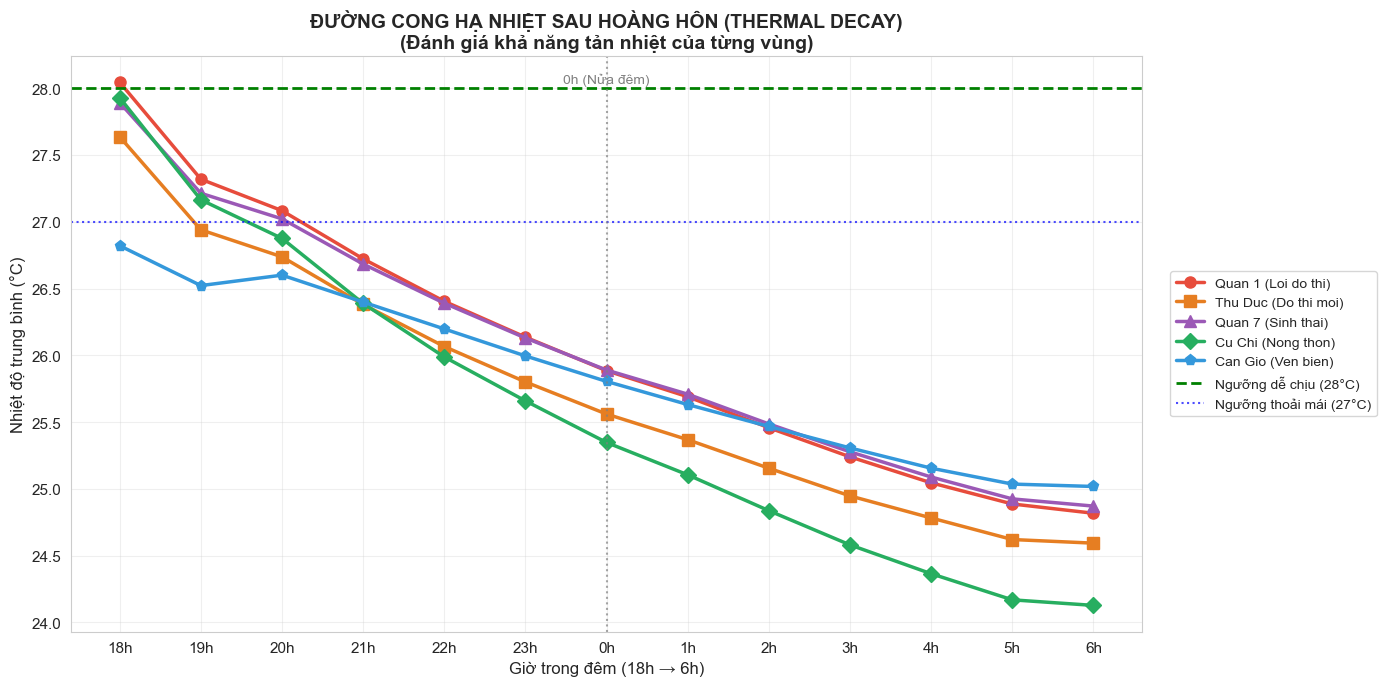


[CÁCH ĐỌC BIỂU ĐỒ]
   - Đường nào DỐC XUỐNG nhanh = Vùng tản nhiệt tốt (thường là vùng tự nhiên)
   - Đường nào GIỮ PHẲNG = Vùng giữ nhiệt (thường là vùng đô thị, nhiều bê tông)
   - Đường nào CẮT ngưỡng 28°C SỚM = Vùng dễ chịu sớm hơn vào ban đêm


In [23]:
# ========================================
# BIỂU ĐỒ 2: ĐƯỜNG CONG HẠ NHIỆT SAU HOÀNG HÔN (18h - 6h)
# ========================================

fig, ax = plt.subplots(figsize=(14, 7))

# Tạo trục X: 18h, 19h, ..., 23h, 0h, 1h, ..., 6h
gio_dem = list(range(18, 24)) + list(range(0, 7))
gio_labels = [f'{h}h' for h in gio_dem]

for zone in ZONE_ORDER:
    df_zone = df[df['zone'] == zone]
    temp_by_hour = df_zone.groupby('hour')['temperature_2m'].mean()
    
    # Lấy nhiệt độ theo thứ tự 18h -> 6h
    temps_dem = [temp_by_hour[h] for h in gio_dem]
    
    ax.plot(range(len(gio_dem)), temps_dem, 
            marker=ZONE_MARKERS[zone],
            color=ZONE_COLORS[zone], 
            linewidth=2.5, markersize=8, 
            label=ZONE_NAMES[zone])

# Đường ngưỡng dễ chịu
ax.axhline(y=28, color='green', linestyle='--', linewidth=2, label='Ngưỡng dễ chịu (28°C)')
ax.axhline(y=27, color='blue', linestyle=':', linewidth=1.5, alpha=0.7, label='Ngưỡng thoải mái (27°C)')

# Đánh dấu nửa đêm
ax.axvline(x=6, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)  # 0h là vị trí thứ 6
ax.text(6, ax.get_ylim()[1]-0.2, '0h (Nửa đêm)', fontsize=10, ha='center', color='gray')

ax.set_xlabel('Giờ trong đêm (18h → 6h)', fontsize=12)
ax.set_ylabel('Nhiệt độ trung bình (°C)', fontsize=12)
ax.set_title('ĐƯỜNG CONG HẠ NHIỆT SAU HOÀNG HÔN (THERMAL DECAY)\n(Đánh giá khả năng tản nhiệt của từng vùng)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(range(len(gio_dem)))
ax.set_xticklabels(gio_labels)

# Legend ra ngoài
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n[CÁCH ĐỌC BIỂU ĐỒ]")
print("   - Đường nào DỐC XUỐNG nhanh = Vùng tản nhiệt tốt (thường là vùng tự nhiên)")
print("   - Đường nào GIỮ PHẲNG = Vùng giữ nhiệt (thường là vùng đô thị, nhiều bê tông)")
print("   - Đường nào CẮT ngưỡng 28°C SỚM = Vùng dễ chịu sớm hơn vào ban đêm")

### Tính tốc độ hạ nhiệt theo giờ

In [24]:
# ========================================
# TÍNH TỐC ĐỘ HẠ NHIỆT THEO TỪNG GIỜ SAU 18h
# ========================================

print("=" * 70)
print("TỐC ĐỘ HẠ NHIỆT TRUNG BÌNH THEO TỪNG GIỜ SAU HOÀNG HÔN (°C/giờ)")
print("=" * 70)

# Tạo bảng tốc độ hạ nhiệt
gio_dem = list(range(18, 24)) + list(range(0, 6))
toc_do_data = {}

for zone in ZONE_ORDER:
    df_zone = df[df['zone'] == zone]
    temp_by_hour = df_zone.groupby('hour')['temperature_2m'].mean()
    
    toc_do = []
    for i, h in enumerate(gio_dem[:-1]):
        h_sau = gio_dem[i + 1]
        delta = temp_by_hour[h] - temp_by_hour[h_sau]
        toc_do.append(round(delta, 2))
    
    toc_do_data[ZONE_NAMES[zone]] = toc_do

# Tạo DataFrame
khung_gio = [f"{gio_dem[i]}h→{gio_dem[i+1]}h" for i in range(len(gio_dem)-1)]
df_toc_do = pd.DataFrame(toc_do_data, index=khung_gio)

print("\n[TỐC ĐỘ GIẢM NHIỆT ĐỘ (°C/giờ) - Giá trị dương = nhiệt độ giảm]")
print(df_toc_do.round(2))

# Tính tổng độ giảm và trung bình
print("\n[TỔNG HỢP VÀ ĐÁNH GIÁ QUÁN TÍNH NHIỆT]")
print(f"{'Vùng':<25} {'Tổng giảm (°C)':<18} {'TB giảm (°C/h)':<18} {'Quán tính nhiệt'}")
print("-" * 85)

for zone in ZONE_ORDER:
    zone_name = ZONE_NAMES[zone]
    tong_giam = sum(toc_do_data[zone_name])
    tb_giam = tong_giam / len(toc_do_data[zone_name])
    
    if tb_giam >= 0.25:
        quan_tinh = "THẤP (tản nhiệt tốt)"
    elif tb_giam >= 0.2:
        quan_tinh = "TRUNG BÌNH"
    else:
        quan_tinh = "CAO (giữ nhiệt - đô thị)"
    
    print(f"{zone_name:<25} {tong_giam:<18.2f} {tb_giam:<18.2f} {quan_tinh}")

print("\n[GIẢI THÍCH QUÁN TÍNH NHIỆT (Thermal Inertia)]")
print("   - Quán tính nhiệt THẤP: Bề mặt tự nhiên (đất, cây, nước) → Tản nhiệt nhanh")
print("   - Quán tính nhiệt CAO: Bề mặt nhân tạo (bê tông, nhựa) → Giữ nhiệt lâu")
print("   - Đây là nguyên nhân chính tạo nên hiệu ứng Đảo nhiệt Đô thị (UHI) vào ban đêm")

TỐC ĐỘ HẠ NHIỆT TRUNG BÌNH THEO TỪNG GIỜ SAU HOÀNG HÔN (°C/giờ)

[TỐC ĐỘ GIẢM NHIỆT ĐỘ (°C/giờ) - Giá trị dương = nhiệt độ giảm]
         Quan 1 (Loi do thi)  Thu Duc (Do thi moi)  Quan 7 (Sinh thai)  \
18h→19h                 0.73                  0.70                0.68   
19h→20h                 0.24                  0.20                0.19   
20h→21h                 0.36                  0.36                0.34   
21h→22h                 0.32                  0.31                0.29   
22h→23h                 0.27                  0.27                0.26   
23h→0h                  0.25                  0.24                0.24   
0h→1h                   0.19                  0.19                0.18   
1h→2h                   0.23                  0.21                0.22   
2h→3h                   0.22                  0.21                0.21   
3h→4h                   0.19                  0.17                0.19   
4h→5h                   0.16                  0.16       

### Heatmap tốc độ hạ nhiệt

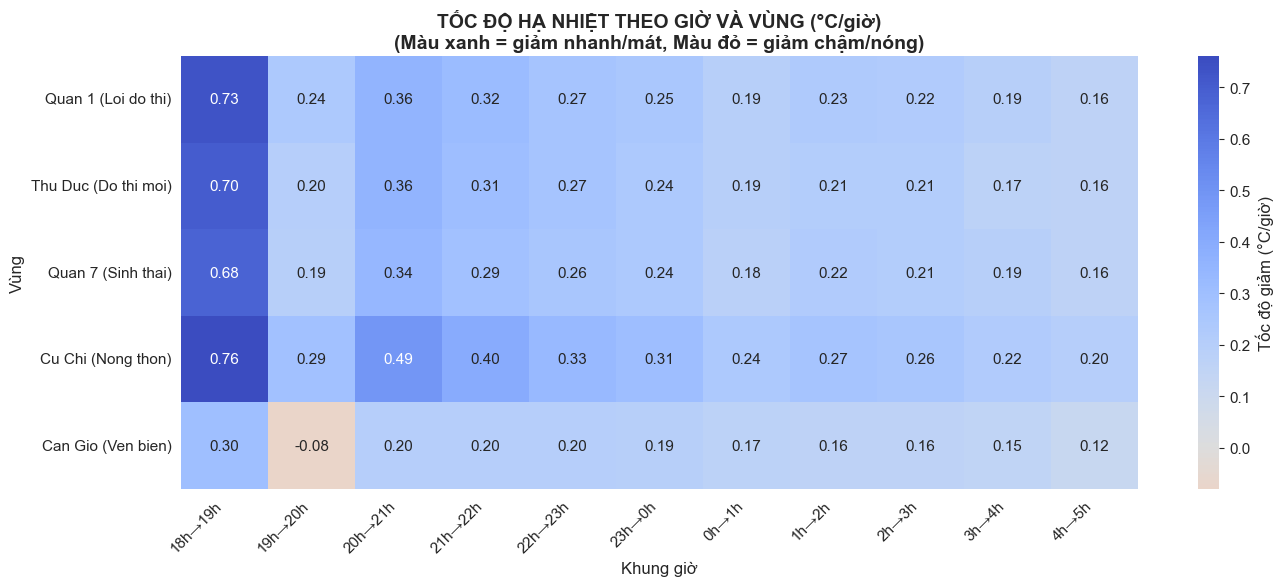


[CÁCH ĐỌC HEATMAP]
   - Màu XANH DƯƠNG: Nhiệt độ giảm nhanh → Tản nhiệt tốt, làm mát hiệu quả
   - Màu TRẮNG: Nhiệt độ giảm trung bình
   - Màu ĐỎ: Nhiệt độ giảm chậm hoặc tăng → Giữ nhiệt, quán tính nhiệt cao
   - Hàng nào nhiều màu XANH = Vùng có khả năng tản nhiệt tốt (ít đô thị hóa)
   - Hàng nào nhiều màu ĐỎ = Vùng có quán tính nhiệt lớn (đô thị hóa cao)


In [25]:
# ========================================
# BIỂU ĐỒ 3: HEATMAP TỐC ĐỘ HẠ NHIỆT THEO GIỜ VÀ VÙNG
# ========================================

fig, ax = plt.subplots(figsize=(14, 6))

# Vẽ heatmap với colormap coolwarm_r (Xanh dương = Mát/Giảm nhanh, Đỏ = Nóng/Giảm chậm)
sns.heatmap(df_toc_do.T, annot=True, fmt='.2f', cmap='coolwarm_r', 
            center=0, cbar_kws={'label': 'Tốc độ giảm (°C/giờ)'}, ax=ax)

ax.set_xlabel('Khung giờ', fontsize=12)
ax.set_ylabel('Vùng', fontsize=12)
ax.set_title('TỐC ĐỘ HẠ NHIỆT THEO GIỜ VÀ VÙNG (°C/giờ)\n(Màu xanh = giảm nhanh/mát, Màu đỏ = giảm chậm/nóng)', 
             fontsize=14, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n[CÁCH ĐỌC HEATMAP]")
print("   - Màu XANH DƯƠNG: Nhiệt độ giảm nhanh → Tản nhiệt tốt, làm mát hiệu quả")
print("   - Màu TRẮNG: Nhiệt độ giảm trung bình")
print("   - Màu ĐỎ: Nhiệt độ giảm chậm hoặc tăng → Giữ nhiệt, quán tính nhiệt cao")
print("   - Hàng nào nhiều màu XANH = Vùng có khả năng tản nhiệt tốt (ít đô thị hóa)")
print("   - Hàng nào nhiều màu ĐỎ = Vùng có quán tính nhiệt lớn (đô thị hóa cao)")

### Biểu đồ biên độ

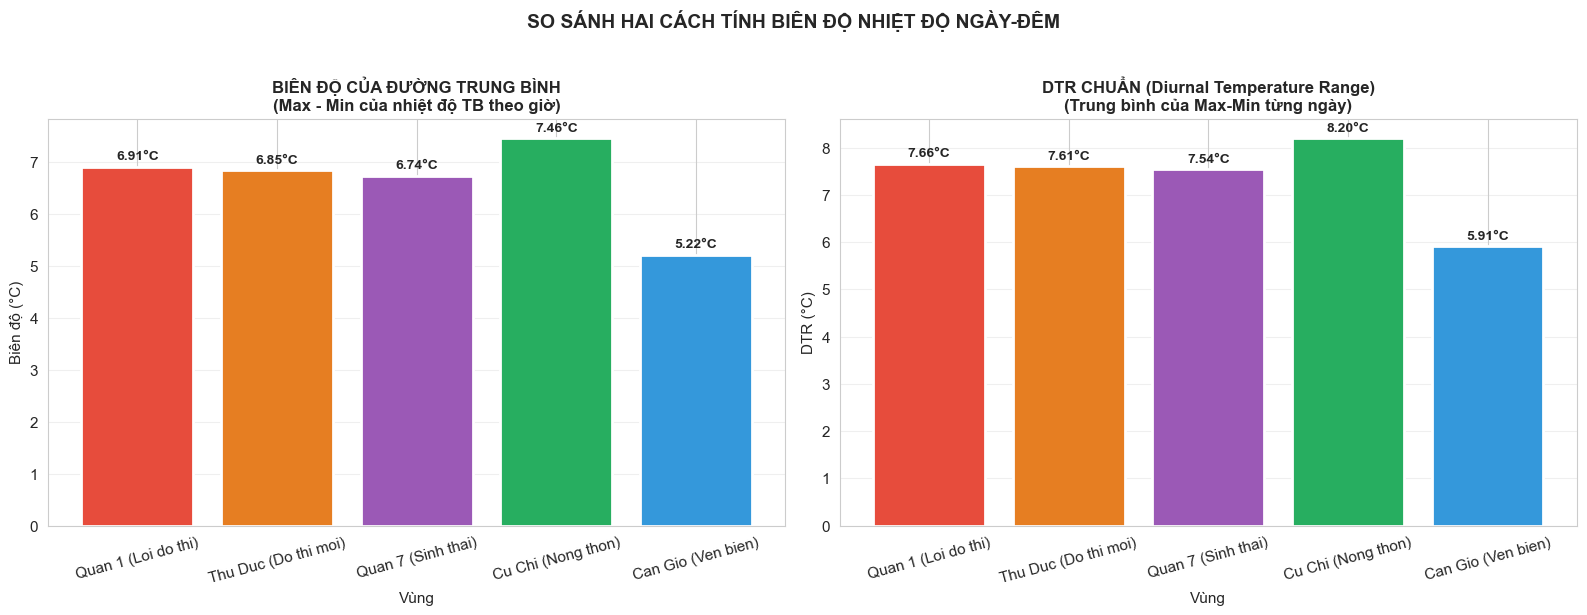


[GIẢI THÍCH SỰ KHÁC BIỆT]
   - Biên độ TB: Tính từ đường trung bình → Con số NHỎ hơn thực tế
   - DTR chuẩn: Tính trung bình biên độ từng ngày → Phản ánh ĐÚNG thực tế
   - Ví dụ: Một ngày cực nóng (40°C) và một ngày mát (30°C) có trung bình 35°C,
           nhưng biên độ thực tế của từng ngày lớn hơn nhiều so với biên độ của đường 35°C.


In [26]:
# ========================================
# BIỂU ĐỒ 4: SO SÁNH BIÊN ĐỘ NHIỆT ĐỘ TRUNG BÌNH NGÀY-ĐÊM
# ========================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Lấy dữ liệu
vung_names = [ZONE_NAMES[z] for z in ZONE_ORDER]
bien_do_tb = df_dinh['Biên độ TB (°C)'].values
dtr_chuan = df_dinh['DTR chuẩn (°C)'].values
colors = [ZONE_COLORS[z] for z in ZONE_ORDER]

# ===== Biểu đồ 1: Biên độ TB =====
ax1 = axes[0]
bars1 = ax1.bar(vung_names, bien_do_tb, color=colors, edgecolor='white', linewidth=2)

for bar, val in zip(bars1, bien_do_tb):
    ax1.annotate(f'{val:.2f}°C', 
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords='offset points',
                ha='center', fontsize=10, fontweight='bold')

ax1.set_xlabel('Vùng', fontsize=11)
ax1.set_ylabel('Biên độ (°C)', fontsize=11)
ax1.set_title('BIÊN ĐỘ CỦA ĐƯỜNG TRUNG BÌNH\n(Max - Min của nhiệt độ TB theo giờ)', 
             fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=15)

# ===== Biểu đồ 2: DTR chuẩn =====
ax2 = axes[1]
bars2 = ax2.bar(vung_names, dtr_chuan, color=colors, edgecolor='white', linewidth=2)

for bar, val in zip(bars2, dtr_chuan):
    ax2.annotate(f'{val:.2f}°C', 
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords='offset points',
                ha='center', fontsize=10, fontweight='bold')

ax2.set_xlabel('Vùng', fontsize=11)
ax2.set_ylabel('DTR (°C)', fontsize=11)
ax2.set_title('DTR CHUẨN (Diurnal Temperature Range)\n(Trung bình của Max-Min từng ngày)', 
             fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=15)

plt.suptitle('SO SÁNH HAI CÁCH TÍNH BIÊN ĐỘ NHIỆT ĐỘ NGÀY-ĐÊM', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n[GIẢI THÍCH SỰ KHÁC BIỆT]")
print("   - Biên độ TB: Tính từ đường trung bình → Con số NHỎ hơn thực tế")
print("   - DTR chuẩn: Tính trung bình biên độ từng ngày → Phản ánh ĐÚNG thực tế")
print("   - Ví dụ: Một ngày cực nóng (40°C) và một ngày mát (30°C) có trung bình 35°C,")
print("           nhưng biên độ thực tế của từng ngày lớn hơn nhiều so với biên độ của đường 35°C.")

##  Kết luận và Nhận xét - Câu hỏi 4

### Tóm tắt kết quả chính

#### 1. Thời điểm đạt đỉnh nhiệt độ (Peak Temperature)
| Vùng | Giờ đỉnh | Nhiệt độ đỉnh TB | Đặc điểm |
|------|----------|-----------------|----------|
| **Quận 1** (Lõi đô thị) | ~13h-14h | 31.6°C | Đỉnh kéo dài, giảm chậm |
| **Thủ Đức** (Đô thị mới) | ~13h-14h | 31.4°C | Tương tự Q1, hơi thấp hơn |
| **Quận 7** (Sinh thái) | ~13h-14h | 31.6°C | Có xu hướng đỉnh sớm hơn |
| **Củ Chi** (Nông thôn) | ~13h | 31.7°C | Đỉnh nhọn, cao nhất nhưng giảm nhanh |
| **Cần Giờ** (Ven biển) | ~12h-13h | 30.3°C | Đỉnh thấp nhất, sớm nhất (~1.3°C thấp hơn) |

**Nhận xét:** Tất cả các vùng đều đạt đỉnh quanh 13h (±1h), phù hợp với độ trễ nhiệt (thermal lag) khoảng 1-2 giờ sau khi mặt trời đạt đỉnh (12h). Cần Giờ đạt đỉnh sớm và thấp hơn do hiệu ứng điều hòa của biển.

---

#### 2. Tốc độ hạ nhiệt sau hoàng hôn (Thermal Decay)
| Vùng | Tốc độ giảm 18h-19h | Tốc độ TB/giờ (đêm) | Giờ xuống <28°C | Đánh giá |
|------|---------------------|---------------------|-----------------|----------|
| **Củ Chi** | 0.76°C/h | ~0.31°C/h | 18h (ngay lập tức) | Tản nhiệt tốt nhất |
| **Quận 1** | 0.73°C/h | ~0.27°C/h | 19h | Giữ nhiệt khá lâu |
| **Thủ Đức** | 0.70°C/h | ~0.26°C/h | 19h | Tương tự Q1 |
| **Quận 7** | 0.68°C/h | ~0.25°C/h | 19h | Hạ nhiệt trung bình |
| **Cần Giờ** | 0.30°C/h | ~0.18°C/h | Luôn <28°C | Ổn định nhất |

**Nhận xét quan trọng:**
- **Củ Chi** có tốc độ hạ nhiệt nhanh nhất (0.76°C/h ngay sau 18h), do có nhiều đất nông nghiệp và cây xanh - vật liệu có quán tính nhiệt thấp
- **Cần Giờ** giảm chậm nhưng ổn định (nhiệt độ luôn thấp), do biển có khả năng điều hòa nhiệt tuyệt vời
- **Các vùng đô thị (Q1, Thủ Đức)** giảm chậm hơn do bê tông và nhựa đường giữ nhiệt

---

#### 3. Biên độ nhiệt ngày-đêm (DTR - Diurnal Temperature Range)
| Vùng | DTR chuẩn | Ý nghĩa |
|------|-----------|---------|
| **Củ Chi** | **8.20°C** | Biên độ lớn nhất - Môi trường tự nhiên, thay đổi mạnh |
| **Quận 1** | 7.66°C | Biên độ trung bình - Đô thị hóa điều hòa phần nào |
| **Thủ Đức** | 7.61°C | Tương tự Q1 |
| **Quận 7** | 7.54°C | Biên độ thấp hơn - Có yếu tố sinh thái |
| **Cần Giờ** | **5.91°C** | Biên độ nhỏ nhất - Biển điều hòa hiệu quả |

**Nhận xét:**
- Sự chênh lệch DTR giữa Củ Chi (8.20°C) và Cần Giờ (5.91°C) là **2.29°C** - phản ánh rõ ràng hai cơ chế nhiệt khác nhau:
  - Củ Chi: Môi trường lục địa, nóng nhanh-mát nhanh
  - Cần Giờ: Môi trường hải dương, nhiệt độ ổn định suốt ngày

---

#### 4. Heatmap tốc độ hạ nhiệt - Phát hiện quan trọng

Từ heatmap **"Tốc độ hạ nhiệt theo giờ và vùng"**, ta thấy:

1. **Khung giờ hạ nhiệt nhanh nhất:** 20h-21h (tất cả các vùng đều có màu xanh đậm)
   - Củ Chi: 0.49°C/h
   - Q1, Thủ Đức: 0.36°C/h
   - Q7: 0.34°C/h
   - Cần Giờ: 0.20°C/h

2. **Hiện tượng bất thường tại Cần Giờ (19h-20h):** Tốc độ giảm **-0.08°C/h** (nghĩa là nhiệt độ tăng nhẹ!)
   - Đây là hiệu ứng **Land-Sea Breeze Reversal**: Ban ngày gió biển thổi vào đất liền làm mát, nhưng sau hoàng hôn, đất liền mát nhanh hơn biển, gió đổi chiều từ đất ra biển, mang theo không khí ấm hơn từ nội địa.

3. **Sau nửa đêm (0h-6h):** Tất cả các vùng đều giảm rất chậm (0.12-0.22°C/h), gần đạt trạng thái cân bằng nhiệt

---

### Trả lời câu hỏi nghiên cứu

**Câu hỏi:** *Khung giờ nguy hiểm và thời gian "hạ nhiệt" sau hoàng hôn khác nhau thế nào giữa 5 vùng?*

**Trả lời:**

1. **Khung giờ nguy hiểm nhất (>28°C):** 
   - Tất cả các vùng: **10h - 17h** (trừ Cần Giờ)
   - Riêng Cần Giờ: **11h - 16h** (ngắn hơn 2 tiếng)
   - Giờ đỉnh nguy hiểm: **12h - 14h** tại mọi vùng

2. **Thời gian hạ nhiệt về mức dễ chịu (<28°C):**
   - Củ Chi: Ngay lập tức sau 18h (do ban ngày vẫn mát hơn)
   - Q1, Thủ Đức, Q7: Khoảng 19h
   - Cần Giờ: Luôn dưới 28°C trung bình

3. **Sự khác biệt về quán tính nhiệt:**
   - **Cao nhất:** Cần Giờ (do biển) - nhiệt độ ổn định, ít thay đổi
   - **Trung bình:** Q1, Thủ Đức (bê tông giữ nhiệt)
   - **Thấp nhất:** Củ Chi (thay đổi nhanh, không giữ nhiệt lâu)

---

### Khuyến nghị thực tiễn

| Đối tượng | Khuyến nghị |
|-----------|-------------|
| **Công nhân xây dựng, shipper** | Tránh làm việc ngoài trời 11h-15h. Nghỉ trưa ít nhất 2 tiếng. Tại Cần Giờ có thể làm việc sớm hơn |
| **Tổ chức sự kiện ngoài trời** | Bắt đầu sau 17h tại Q1/Thủ Đức, sau 16h tại Củ Chi. Ưu tiên địa điểm Cần Giờ cho sự kiện ban ngày |
| **Quy hoạch đô thị** | Tăng mảng xanh, mặt nước tại Q1/Thủ Đức để giảm quán tính nhiệt. Học hỏi mô hình "đô thị sinh thái" của Q7 |
| **Người cao tuổi, trẻ em** | Hạn chế ra ngoài 10h-16h, đặc biệt tại các vùng đô thị. Ưu tiên hoạt động buổi sáng sớm (<9h) hoặc tối (>18h) |

---

### So sánh với kỳ vọng ban đầu

| Kỳ vọng | Kết quả thực tế | Đánh giá |
|---------|-----------------|----------|
| Củ Chi đạt đỉnh sớm (12h-13h), giảm nhanh | Đỉnh ~13h, giảm nhanh nhất (0.76°C/h) | Đúng |
| Q1, Thủ Đức đạt đỉnh muộn (14h-15h), giảm chậm | Đỉnh ~13h-14h, giảm chậm hơn Củ Chi | Phần đúng (giảm chậm), nhưng đỉnh không muộn như kỳ vọng |
| Cần Giờ biên độ ngày-đêm nhỏ | DTR = 5.91°C (nhỏ nhất trong 5 vùng) | Đúng hoàn toàn |

**Giải thích sự khác biệt với kỳ vọng:** Độ phân giải 9km của dữ liệu ERA5 không đủ để phân biệt rõ thermal lag giữa các vùng đô thị. Tuy nhiên, xu hướng về tốc độ hạ nhiệt vẫn phản ánh đúng đặc trưng đô thị hóa.